# Load Libraries

In [1]:
from Code import *
from scipy.special import gamma
from scipy.stats import poisson
from numpy import linalg
from copy import copy, deepcopy
import math
from multiprocessing import Process, Pool, cpu_count
from functools import partial
from scipy import interpolate
from scipy import integrate
from matplotlib import colors
import matplotlib.cm as cmx
from random import gauss
import datetime
import os
from scipy.interpolate import LinearNDInterpolator
from scipy.stats import chi2

## Quick flags for enabling/disabling features consuming time and memory

In [2]:
writeJSON = True #Necessary to (re)write JSON files?
forceNSIcalc = False  #Force regeneration of NSI xsec grid? Else read preious grid from json if available
LHAPDFcalc = False  #False: skip codes invoking external LHAPDF if a precomputed NSI grid exists

In [3]:
#Ensure dirs for output json files and plots exist
if not os.path.exists('fitspectra/'): os.makedirs('fitspectra/')
if not os.path.exists('plots/'): os.makedirs('plots/')
    
#Define different flux components
#N.B. if decomposition too fine, also possible to combine particle contributions e.g.
#  "pi": {"type":"light", "id": [211,-211], "ltx":r'$\pi^\pm$'},\           
origins = {"pi+":        {"type":"light", "id": [  211      ], "ltx":r'$\pi^+$'},\
           "pi-":        {"type":"light", "id": [ -211      ], "ltx":r'$\pi^-$'},\
           "K+":         {"type":"light", "id": [  321      ], "ltx":r'$K^+$'},\
           "K-":         {"type":"light", "id": [ -321      ], "ltx":r'$K^-$'},\
           "K0":         {"type":"light", "id": [  130,  310], "ltx":r'$K_{L/S}^0$'},\
           "Lambda0":    {"type":"light", "id": [ 3122      ], "ltx":r'$\Lambda^0$'},\
           "Lambda0bar": {"type":"light", "id": [-3122      ], "ltx":r'$\overline{\Lambda^0}$'},\
           "D0":         {"type":"charm", "id": [  421      ], "ltx":r'$D^0$'},\
           "D0bar":      {"type":"charm", "id": [ -421      ], "ltx":r'$\overline{D^0}$'},\
           "D+":         {"type":"charm", "id": [  411      ], "ltx":r'$D^+$'},\
           "D-":         {"type":"charm", "id": [ -411      ], "ltx":r'$D^-$'},\
           "Ds+":        {"type":"charm", "id": [  431      ], "ltx":r'$D_s^+$'},\
           "Ds-":        {"type":"charm", "id": [ -431      ], "ltx":r'$D_s^-$'},\
           "Lambdac+":   {"type":"charm", "id": [ 4122      ], "ltx":r'$\Lambda_c^+$'}}
#The directory structure of vpids is useful for JSON I/O
vpids = {12:[],-12:[],14:[],-14:[],16:[],-16:[]}  #Use all available nu flavors where unspecified (global)
Nptypes = len(list(origins.keys()))

#Introduce plastic scintillators for run 4 FASER and hi-lumi FASER2
#Also update FASERv lumi to run concurrently with FASER-PS
#Basic design: 10 cm radius, 20 cm length, 690/fb for run 4 or 3/ab for HL-LHC. 
#Using polyethylene density (0.91-0.925 g/cm3), pure carbon/graphite would have 2.2 g/cm3
#Per FK recommendation, applying density 1.03 for the PS as of 250331
experimentsadd = {"FASER-PS"  : {"length": 20.0, "rho": 1.03, "material": "C", "posz": 480, "lumi": 680,
                                 "xmin": -.1, "xmax": .1, "ymin": -.1, "ymax": .1 },
                  #"FASER-C"   : {"length": 10.0, "rho": 2.2, "material": "C", "posz": 480, "lumi": 680,
                  #               "xmin": -.1, "xmax": .1, "ymin": -.1, "ymax": .1 },
                  #Disc of radius 20 cm
                  "FASER2-PS" : {"length": 20.0, "rho": 1.03, "material": "C", "posz": 620, "lumi":3000,
                                 "xmin": -.2, "xmax": .2, "ymin": -.2, "ymax": .2 }}
#Slightly more accurate description of the FASERv run3 configuration, but lumi corresponding to period w/ plastic scintillator installed
experiments['FASERv'] =  {"length": 80,  "rho": 19.3, "material": "W", "posz": 480, "lumi": experimentsadd["FASER-PS"]["lumi"],
                          "xmin": -.125, "xmax": .125,"ymin": -.150,   "ymax": .150 }
#A larger FASER2-PS corresponding to the full rectangular area of FASERv2
experimentsadd['FASER2-PSL'] =  experimentsadd['FASER2-PS']
experimentsadd['FASER2-PSL']['xmin'] = experiments['FASERv2']['xmin']
experimentsadd['FASER2-PSL']['xmax'] = experiments['FASERv2']['xmax']
experimentsadd['FASER2-PSL']['ymin'] = experiments['FASERv2']['ymin']
experimentsadd['FASER2-PSL']['ymax'] = experiments['FASERv2']['ymax']
#Update experiments array to contain additions
experiments.update(experimentsadd)

#List detectors for which to compute the spectra. 
#To combine several detectors, it is best to sum the results of the model computation.
#This assumes initial nu-flux loss at previous detector negligible at the next one,
#but allows most control in individual R-binning
detectors = ['FASERv','FASER-PS','FASERv2','FASER2-PS','FASER2-PSL']

#Determine which vpids are available per detector.
#If CID available, specify both + and - ID. If unavailable, only + ID.
#If the neutrino flavor cannot be measured at all, give neither + or - ID.
#Returns the IDs as int, in analogy with the global vpids.
def detectorvpidstrs(detector):
    if   detector=='FASERv2':   return ['12',      '14','-14','16']
    elif detector=='FASER2-PS': return ['12','-12','14','-14'     ]
    elif detector=='FASERv':    return ['12',      '14','-14','16']
    elif detector=='FASER-PS':  return ['12','-12','14','-14'     ]
    else:
        #Assume detectability of all vpids activated in this notebook
        global vpids
        return [str(x) for x in list(vpids.keys())]

#Define the generators to be investigated
##Suitable for very large detectors
#N.B. CID code is currently tailored for one generator pair only! If generalized, check also load_json
gens = [['SIBYLL','POWHEG'],
        #['EPOSLHC', 'SIBYLL'],
        #['QGSJET', 'BKRS'  ]
       ]
#fluxfileprefix = 'VLarge'
fluxfileprefix = 'Run4'

genpairBL = {'light':gens[0][0],'charm':gens[0][1]}
genpairBLstr = '&'.join(list(genpairBL.values()))

#Gen.s in 1st col above are for light contributions, 2nd col for charm
genpars=['light', 'charm']

#Ensure proper formatting of input gens table
if np.array(gens[0]).ndim==0:
    gens = np.array([[g] for g in gens])
else:
    gens = np.array(gens)

#Numbers of independent generators in different "sectors", e.g. 0=light and 1=charm 
Ng = len(gens)  #Number of all generator( pair)s
Ngi=[]          #Number of indep. gen. per particle type
Nginames=[]     #Names of the gen. corresponding to^, helps in lambdamatrix interpretation
for isec in range(len(gens[0])):
    indeps=[]
    for g in gens[:,isec]:
        if g not in indeps:
            indeps.append(g)
    Ngi.append(len(indeps))
    Nginames.append(indeps)

#Assign numbers of gens to be used for different particle type
icharm = genpars.index('charm') if 'charm' in genpars else 0
ilight = genpars.index('light') if 'light' in genpars else 0
Ngp     =[     Ngi[icharm if origins[origin]["type"]=='charm' else ilight] for origin in origins]
Ngpnames=[Nginames[icharm if origins[origin]["type"]=='charm' else ilight] for origin in origins]
gptypes =[        'charm' if origins[origin]["type"]=='charm' else 'light' for origin in origins]

#To store default values for all lambdas
#Redefining the "zero" allows studying e.g. single-generator-centered models
#By default, keep this at zero for the average of all predictions, 
#then redefine using e.g. genPairLambdaMatrix, and reset back to original afterwards

#Tags indicating the name of the code producing various plots etc.
#Due to many predictions' abbreviations starting with the same letter, we can't simply take the first letter for
#every prediction for filetagging purposes but define a few custom labels here.
codename='cid'
for ig in range(len(genpars))[::-1]:
    codename += '_l' if genpars[ig]=='light' else 'c'
    for g in gens[:,ig]:
        gentag=g[0]
        if 'BKSS' in g:
            gentag='A'
        elif 'BDGJKR' in g:
            gentag='Y'
        codename += gentag
fitspectratag='fitspectra/'+codename+'_'
#Just one lambda per particle type for now, but matrix structure left for generality
BLdimRed = 0 if 'cid' in codename else 1
lambdaBL = [np.zeros(n-BLdimRed) for n in Ngp]  #All-zero lambdas default to central predicton

## Obtaining the Spectra from Event Files
In the following, we write a function `get_binned_spectra()` that takes the data from the event files and fills it into histograms. In particular it needs: 
- `inputs`: a set of input files whose contents are to be summed in order to obtain a single spectrum; e.g. two filenames typically pointing to 'files/': one containing light contributions from and another containing charm contributions
- `outputfile`: the name of the output file in `.csv` format stored under `fitspectra`
- `experiment`: the name of the experiment (options are defined in `code.py`)
- `ebins`: the binning in energy
- `rbins`: binning in radial position

The output file records the number of both neutrinos and neutrino interactions for different neutrino flavours, flux components, energy bins, and radial bins. 

In [4]:
def get_binned_spectra(inputgen, outputfile, experiment, ebins, rbins):
    
    global vpids
    global fluxfileprefix
    global genpars
    global experiments
    
    # detector
    xmin = experiments[experiment]["xmin"]
    ymin = experiments[experiment]["ymin"]
    xmax = experiments[experiment]["xmax"]
    ymax = experiments[experiment]["ymax"]
    posz = experiments[experiment]["posz"]
    lumi = experiments[experiment]["lumi"]
    
    # initiate samples, loop through files and eventsp
    samples={}
    for vpid in vpids:
        samples[vpid]={}
        for origin in origins: samples[vpid][origin]=[]
    expstr = 'FASER2' if 'FASER2' in experiment else 'FASER' 
    inputs = ['files/'+fluxfileprefix+'_'+expstr+'_'+genpars[i]+'_'+inputgen[i]+'.txt'\
              for i in range(len(inputgen))]
    for filename in inputs:
        events = readfile_txt(filename)
        deltax = -np.arctan(0.000250)*experiments[experiment]['posz'] if '/Run4_' in filename else 0.0  #Center beam
        for event in events:
            vpid, hpid, x0, y0, z0, thx, thy, en, w = event
            acc = 1.0  #Introduce acceptance related factors to reduce statistics here, if need be
            w *= acc
            vpid, hpid = int(vpid), int(hpid)
            x = x0 + thx*(posz-480) + deltax
            y = y0 + thy*(posz-480)
            r = np.sqrt(x**2+y**2)
            if x<xmin or x>xmax: continue
            if y<ymin or y>ymax: continue
            probcc = get_interaction_probability(experiment,en,str(vpid))
            probnc = get_interaction_probability(experiment,en,str(vpid),xsprefix="nc")
            for origin in origins:
                if hpid in origins[origin]['id']: samples[vpid][origin].append([en,r,w,w*probcc,w*probnc])        
    
    # extract and save in pandas
    data = {}
    for vpid in vpids:
        data[vpid]={}
        for origin in origins:
            data[vpid][origin] = {}
            
            # get histograms
            flux={}
            ratecc={}
            ratenc={}
            sample = np.array(samples[vpid][origin])
            if len(sample)==0: 
                flux  =np.array([[0 for _ in rbins[:-1]] for _ in ebins[:-1]])
                ratecc=np.array([[0 for _ in rbins[:-1]] for _ in ebins[:-1]])
                ratenc=np.array([[0 for _ in rbins[:-1]] for _ in ebins[:-1]])
            else:
                flux,_,_  =np.histogram2d(sample.T[0],sample.T[1],weights=sample.T[2],bins=[ebins,rbins])
                ratecc,_,_=np.histogram2d(sample.T[0],sample.T[1],weights=sample.T[3],bins=[ebins,rbins])
                ratenc,_,_=np.histogram2d(sample.T[0],sample.T[1],weights=sample.T[4],bins=[ebins,rbins])
                
            # store bins to data
            data[vpid][origin]['ebins']=ebins.tolist() 
            data[vpid][origin]['rbins']=rbins.tolist()

            # store numbers of incoming neutrinos and interactions
            for name,arr in zip(['n_nu','n_cc','n_nc'],[flux,ratecc,ratenc]):
                data[vpid][origin][name]=(lumi*1000*arr).tolist() 
    
    # convert to data frame and save
    global fitspectratag
    save_json(fitspectratag+outputfile,data)

Let's get the spectra for the generators in the requested experiment (e.g. FASERv,...). Below is a handle to the get_binned_spectra function, for enabling multiprocessing.
    
Parameters
- `ituples`: [int,int], indices for the generator(pair) and detector to use


In [5]:
def get_bins(detector):
    #FASERv bins (default)
    ebins = np.logspace(1,4,16)   #5 bins per decade
    ebinsPS = np.logspace(1,4,31)  #Init a fine binning for PS to  be used for "theory" lvl, coarsed down to "data" lvl later
    rbins1 = np.array([0,0.2])
    rbins3 = np.array([0,0.06,0.13,0.2])
    #Binning for FASER2-related detectors
    if detector=='FASERv2':
        rbins1 = np.array([0,0.3])
        rbins3 = np.array([0,0.1,0.2,0.3])
    elif detector=='FASER2-PS':  
        ebins = ebinsPS
        rbins1 = np.array([0,0.2])            #Disc w/ radius 20 cm 
        rbins3 = np.array([0,0.07,0.14,0.2])  #Disc w/ radius 20 cm
    elif detector=='FASER2-PSL':  
        ebins = ebinsPS
        rbins1 = np.array([0,0.3])           #Corresponding to rectangular FASERv2 area
        rbins3 = np.array([0,0.1,0.2,0.3])   #Corresponding to rectangular FASERv2 area
        #rbins1 = np.array([0,1.6])          #3m x 1m area, corresponding to spectrometer size
        #rbins3 = np.array([0,0.5,1.0,1.6])  #3m x 1m area, corresponding to spectrometer size
    elif detector=='FASER-PS':  #Radius 10cm
        ebins = ebinsPS
        rbins1 = np.array([0,0.1])
        rbins3 = np.array([0,0.03,0.06,0.1])
    elif detector=='FASER-C':  #Radius 10cm
        ebins = ebinsPS
        rbins1 = np.array([0,0.1])
        rbins3 = np.array([0,0.03,0.06,0.1])
    ecenters = [(ebins[i]+ebins[i+1])*0.5 for i in range(len(ebins)-1)]
    return ebins,ecenters,rbins1,rbins3

In [6]:
#A handle to get all radN cases for one generator(pair), for multiprocessing
def get_binned_spectra_handle(ituples):

    global gens
    processed=0
    
    for ituple in ituples:
        igen,idet = ituple
        gen = gens[igen]
        detector = detectors[idet]
        savejsonname = '_'.join(gen)+'_'+detector
        ebins,_,rbins1,rbins3 = get_bins(detector)
        get_binned_spectra(
            outputfile = savejsonname+'_rad1',
            inputgen = gen,
            experiment=detector,
            ebins=ebins,
            rbins=rbins1
        )
        get_binned_spectra(
            outputfile = savejsonname+'_rad3',
            inputgen = gen,
            experiment=detector,
            ebins=ebins,
            rbins=rbins3
        )
        processed += 1
        progstr = str(processed)+'/'+str(len(ituples))
        print('A get_binned_spectra process has written '+progstr+' JSONs',ituple)

In [7]:
#Fetch spectra for different generators and radial bin cases via the above handle
if writeJSON:
    #Construct array of generator pair and detector indices for the processes
    procind = [[i,j] for j in range(len(detectors)) for i in range(len(gens))]
    print('Total of '+str(len(procind))+' index pairs to consider:',procind)
    
    Nmax = 8  #Divide into max this many blocks, "number of CPUs"
    step = int(np.ceil(len(procind)/Nmax))
    procind_divided = [procind[n*step:(n+1)*step] for n in range(Nmax)]
    
    #Check for possibility that all available processes weren't assigned jobs
    N = min(sum([len(pd)!=0 for pd in procind_divided]),Nmax)
    procind_final = procind_divided[:N]
    print('With Nmax = '+str(Nmax)+', optimal to consider '+str(N)+' index pairs:')
    for pd in procind_final: print(pd)
    readprocs = Pool(processes=N)
    readprocs.map(get_binned_spectra_handle, procind_final)

Total of 5 index pairs to consider: [[0, 0], [0, 1], [0, 2], [0, 3], [0, 4]]
With Nmax = 8, optimal to consider 5 index pairs:
[[0, 0]]
[[0, 1]]
[[0, 2]]
[[0, 3]]
[[0, 4]]
A get_binned_spectra process has written 1/1 JSONs [0, 3]
A get_binned_spectra process has written 1/1 JSONs [0, 4]
A get_binned_spectra process has written 1/1 JSONs [0, 1]
A get_binned_spectra process has written 1/1 JSONs [0, 0]
A get_binned_spectra process has written 1/1 JSONs [0, 2]


### LHAPDF machinery and DIS cross sections with variable couplings

In [8]:
if LHAPDFcalc:
    import lhapdf
    lhapdf.pathsPrepend("/home/user/install/share/LHAPDF/") #Path to stored PDF sets

    class MyPDF:
        
        def __init__(self, pdf_name, nuclear_pdf=True):
            
            self.z, self.a, self.n  = 74., 184., 110.
            self.nuclear_pdf  = nuclear_pdf
            self.pdf_name = pdf_name
            self.pdf = lhapdf.mkPDF(pdf_name)
                
        def xfx(self, pid, x, q2):
            
            if self.nuclear_pdf:
                return self.pdf.xfxQ2(pid, x, q2) 
            else: 
                if pid == 1: 
                    return self.z/self.a*self.pdf.xfxQ2(1, x, q2) + self.n/self.a*self.pdf.xfxQ2(2, x, q2) # d(n)=u(p)
                elif pid == 2: 
                    return self.z/self.a*self.pdf.xfxQ2(2, x, q2) + self.n/self.a*self.pdf.xfxQ2(1, x, q2) # d(n)=u(p)
                elif pid == -1: 
                    return self.z/self.a*self.pdf.xfxQ2(-1, x, q2) + self.n/self.a*self.pdf.xfxQ2(-2, x, q2) # d(n)=u(p)
                elif pid == -2: 
                    return self.z/self.a*self.pdf.xfxQ2(-2, x, q2) + self.n/self.a*self.pdf.xfxQ2(-1, x, q2) # d(n)=u(p)
                else: 
                    return self.pdf.xfxQ2(pid, x, q2)
    

**Standard Model:** The SM differential neutrino scattering cross section at high energy are approximately given by 

- NC Neutrino Scattering 
\begin{equation}
\frac{d\sigma(\nu N \to \nu X)}{dx \ dy} = \frac{ 2G_F^2 m_p E_\nu}{ \pi} \frac{m_{Z}^4}{(Q^2+m_{Z}^2)^2} \times  \sum_{q=u,d,s,c} \big[ g_{q,L}^2 [x f_{q}(x,Q^2) + x f_{\bar{q}}(x,Q^2)(1-y)^2 ] + g_{q,R}^2 [x f_{q}(x,Q^2) (1-y)^2 + x f_{\bar{q}}(x,Q^2) ] \big ] \ ,
\end{equation}

- NC Anti-Neutrino Scattering 
\begin{equation}
\frac{d\sigma(\nu N \to \nu X)}{dx \ dy} = \frac{ 2G_F^2 m_p E_\nu}{ \pi} \frac{m_{Z}^4}{(Q^2+m_{Z}^2)^2} \times  \sum_{q=u,d,s,c} \big[ g_{q,L}^2 [x f_{q}(x,Q^2)(1-y)^2 + x f_{\bar{q}}(x,Q^2)] + g_{q,R}^2 [x f_{q}(x,Q^2) + x f_{\bar{q}}(x,Q^2) (1-y)^2] \big ] \ ,
\end{equation}

**Neutrino Non-Standard Interactions (NSI)**

As stated in 2012.10500:
\begin{equation}
\mathcal{L}_{\rm NSI}
=-\sqrt{2}G_F
  \sum_{f,\alpha,\beta}
  \left(\overline{\nu}_\alpha \gamma^\mu P_L \nu_\beta\right)
  \left(\epsilon^{f,V}_{\alpha\beta} \overline{f} \gamma_\mu f
  +\epsilon^{f,A}_{\alpha\beta} \gamma_\mu \gamma^5 f\right)
\end{equation}

Then we take
\begin{align}
\begin{cases}
g^q_L &= \frac{1}{2}(g^q_V-g^q_A)\\
g^q_R &= \frac{1}{2}(g^q_V+g^q_A)
\end{cases}
\end{align}

Then the SM couplings
\begin{align}
\begin{cases}
g_L^d &= -1/2 +   \sin^2\theta_W / 3\\
g_L^u &=  1/2 - 2 \sin^2\theta_W / 3\\
g_R^d &=    \sin^2\theta_W / 3\\
g_R^u &= -2 \sin^2\theta_W / 3\\
\end{cases}
\end{align}
are modified by introducing $\epsilon^{qV/A}_{ab}$, $a,b\in\{e,\mu,\tau\}$. 

Then, presume that when computing 
$\sigma_{ab} \equiv \sigma(\nu_a\to \ell_b + ...),~a,b\in\{e,\mu,\tau\}$, 
we have 
$\Delta g_{V/A}^{q}|_{\sigma_{ab}} = \epsilon^{qV/A}_{ab}$, so we get
\begin{equation*}
\Delta g_L^q|_{\sigma_{ab}} = \frac{1}{2} (\epsilon^{qV}_{ab} - \epsilon^{qA}_{ab}),\quad
\Delta g_R^q|_{\sigma_{ab}} = \frac{1}{2} (\epsilon^{qV}_{ab} + \epsilon^{qA}_{ab}).
\end{equation*}

In [9]:
#define constants
g_fermi = 1.1663787 * 1e-5
gLSM = 0.5
gSM = 0.652904
#mW = 80.379
mZ = 91.187
mproton = 0.938272
nq = 6   #Number of considered quark flavors
igev2_in_cm2 = 0.3894 * 1e-27
cosW2 = 0.7771

class MyDIS():

    def __init__(self, pdf):
        self.pdf = pdf
        self.mV  = 0
        self.cvL = 0
        self.cvR = 0
        self.cqL = 0
        self.cqR = 0
        #NSI coefficients. No lepton indices here; if you need e.g. eps_ee and eps_mumu, initiate MyDIS separately.
        self.epsA = [0 for _ in range(nq)]  #Axial,  n.b. indices offset by -1 vs pid / PDG index
        self.epsV = [0 for _ in range(nq)]  #Vector, n.b. indices offset by -1 vs pid / PDG index
        
    def initialize(self,mV=1000,cv=0,cq=0,epsA=[0 for _ in range(nq)],epsV=[0 for _ in range(nq)]):
        self.mV  = mV
        self.cvL = cv
        self.cvR = cv
        self.cqL = cq
        self.cqR = cq
        self.epsA = epsA
        self.epsV = epsV
        
    def gL(self,pid):
        sw2 = 0.222
        pidm1 = abs(pid)-1  #Abbreviate, helpful due to index offset in epsV, epsA
        if abs(pid) in [1 ,3 ,5 ]: return -0.5 +    sw2/3. + (self.epsV[pidm1]-self.epsA[pidm1])*0.5  #d-quarks
        if abs(pid) in [2 ,4 ,6 ]: return  0.5 - 2.*sw2/3. + (self.epsV[pidm1]-self.epsA[pidm1])*0.5  #u-quarks
        if abs(pid) in [12,14,16]: return  0.5                                                        #Nu e,mu,tau
        
    def gR(self,pid):
        sw2 = 0.222
        pidm1 = abs(pid)-1  #Abbreviate, helpful due to index offset in epsV, epsA
        if abs(pid) in [1 ,3 ,5 ]: return     sw2/3. + (self.epsV[pidm1]+self.epsA[pidm1])*0.5  #d-quarks
        if abs(pid) in [2 ,4 ,6 ]: return -2.*sw2/3. + (self.epsV[pidm1]+self.epsA[pidm1])*0.5  #u-quarks
        if abs(pid) in [12,14,16]: return 0                                                     #Nu e,mu,tau
    
    #-------------------------------------------------
    def dsigma_dxdy_NC_nu(self, energy, x, y):
        q2 = x * 2 * mproton * y * energy
        prefactor = 2. * g_fermi**2 * mproton * energy / math.pi * mZ**4 / (q2+mZ**2)**2
        pdfpart = 0
        for i in [1,2,3,4]:
            pdfpart += (self.gL(i))**2 * (self.pdf.xfx(i,x,q2) + self.pdf.xfx(-i,x,q2)*(1-y)**2)
            pdfpart += (self.gR(i))**2 * (self.pdf.xfx(i,x,q2)*(1-y)**2 + self.pdf.xfx(-i,x,q2))
        return prefactor * pdfpart * igev2_in_cm2
    
    def dsigma_dxdy_NC_nubar(self, energy, x, y):   
        q2 = x * 2 * mproton * y * energy
        prefactor = 2. * g_fermi**2 * mproton * energy / math.pi * mZ**4 / (q2+mZ**2)**2
        pdfpart = 0
        for i in [1,2,3,4]:
            pdfpart += (self.gL(i))**2 * (self.pdf.xfx(i,x,q2)*(1-y)**2 + self.pdf.xfx(-i,x,q2))
            pdfpart += (self.gR(i))**2 * (self.pdf.xfx(i,x,q2) + self.pdf.xfx(-i,x,q2)*(1-y)**2)
        return prefactor * pdfpart * igev2_in_cm2

    #-------------------------------------------------
    # built-in python integration (slow but optimized)
    def sigma_total(self,func, energy):

        def function(x,y): return func(energy,x,y)
        sigma = integrate.nquad(function, [ [10**-4,1], [10**-4,1]])[0]
        return sigma

    # hand-written integration routine (faster, but possibly less accurate)
    def sigma_total_manual(self,func, energy, n_step=15):

        #integration boundaries
        logx_min, logx_max = math.log(1e-3), 0
        dlogx = (logx_max - logx_min) / n_step
        logy_min, logy_max = math.log(1e-3), 0
        dlogy = (logy_max - logy_min) / n_step

        #integration
        sigma=0
        for logx in np.linspace(logx_min+0.5*dlogx, logx_max-0.5*dlogx, n_step):
            for logy in np.linspace(logy_min+0.5*dlogy, logy_max-0.5*dlogy, n_step):
                x = math.exp(logx);
                y = math.exp(logy);
                sigma += func(energy, x, y) * x * y 
        sigma *= dlogy * dlogx
        return sigma
    
    #-------------------------------------------------
    def sigma(self,process,energy,manual=False):
        if process=="CC_nu":
            if manual: return self.sigma_total_manual(self.dsigma_dxdy_CC_nu, energy)
            else: return self.sigma_total(self.dsigma_dxdy_CC_nu, energy)
        elif process=="CC_nubar":
            if manual: return self.sigma_total_manual(self.dsigma_dxdy_CC_nubar, energy)
            else: return self.sigma_total(self.dsigma_dxdy_CC_nubar, energy)
        elif process=="NC_nu":
            if manual: return self.sigma_total_manual(self.dsigma_dxdy_NC_nu, energy)
            else: return self.sigma_total(self.dsigma_dxdy_NC_nu, energy)
        elif process=="NC_nubar":
            if manual: return self.sigma_total_manual(self.dsigma_dxdy_NC_nubar, energy)
            else: return self.sigma_total(self.dsigma_dxdy_NC_nubar, energy)

#### Test xsec calculation

In [10]:
if LHAPDFcalc:
    #pdf = MyPDF(pdf_name="nCTEQ15FullNuc_12_6/0", nuclear_pdf=True)
    pdf = MyPDF(pdf_name="nCTEQ15FullNuc_184_74/0", nuclear_pdf=True)
    dis = MyDIS(pdf)
    print("total NC neutrino cross section for E=1TeV:", dis.sigma("NC_nu",1023.29)*184, "cm^2")
    print("total NC anti-neutrino cross section for E=1TeV:", dis.sigma("NC_nubar",1023.29)*184, "cm^2")
    
    #Test NSI
    dis.initialize(epsA=[-1.,0,0,0,0,0],epsV=[0,0,0,0,0,0])
    print("NSI neutrino cross section (1TeV):", dis.sigma("NC_nu",1023.29)*184, "cm^2")
    dis.initialize(epsA=[0,0,0,0,0,0],epsV=[0,0,0,0,0,0])  #Reinit to SM

### Compute NSI xsec

Compute 3D grids of the values sigma(epsA,epsV,E) for u,d, and mumu
The grids are written to a JSON file, that doesn't have to be (re)computed unless an existing grid file isn't found.
The model calculation then calls an interpolation function. The SM result is obtained by setting epsA = epsV = 0.

First initiate the $(\epsilon^V,\epsilon^A)$ grid axis variables, 
and the dictionary structure where to store the results.

In [11]:
epsgrid = np.linspace(-1.5,1.5,21)  #Wilson coefficient grid points

NSIxsec={}
if os.path.exists(fitspectratag+'NSIxsec.json') and not forceNSIcalc:
    NSIxsec = load_json(fitspectratag+'NSIxsec')
elif LHAPDFcalc:
    forceNSIcalc = True
    for detector in ['FASERv','FASERv2']:
        _,ecenters,_,_ = get_bins(detector)
        NSIxsec[detector]={}
        for vpid in detectorvpidstrs(detector):
            NSIxsec[detector][vpid]={}
            for q in ['d','u','s','c','b','t']:
                NSIxsec[detector][vpid][q] = np.zeros([len(epsgrid),len(epsgrid),len(ecenters)]).tolist()

In [12]:
#AUX function for parallelization to scan over one epsilon (w/ the other one fixed) for a given detector
def epsilonscan(iArange,detector,vpid,iq):

    global experiments
    global epsgrid
    
    #Set PDF depending on experiment
    mattag = '184_74'  #Default W
    if   experiments[detector]['material']=='C' : mattag = '12_6'
    elif experiments[detector]['material']=='Ar': mattag = '40_18'
    elif experiments[detector]['material']=='Fe': mattag = '56_26'
    pdf = MyPDF(pdf_name="nCTEQ15FullNuc_"+mattag+"/0", nuclear_pdf=True)
    disNSI = MyDIS(pdf)    
    
    #Check which energies and which xsec to compute
    ebins,ecenters,_,_ = get_bins(detector)    
    NSIstr = 'NC_nu' if '-' not in vpid else 'NC_nubar'
    
    #Scan over requested epsV, epsA for a particular process
    ret=[]
    for iA in iArange:
        ret.append([])  #Init iV index
        epsAval=epsgrid[iA]
        for iV,epsVval in enumerate(epsgrid):
            epsA,epsV=[0 for _ in range(nq)],[0 for _ in range(nq)]  #Init to no NSI
            epsV[iq] = epsVval
            epsA[iq] = epsAval
            disNSI.initialize(epsA=epsA,epsV=epsV)
            xs = np.array([disNSI.sigma(NSIstr,ecenter) for ecenter in ecenters])
            #If no CID for this flavor, sum nu and nubar contributions
            if '-' not in vpid and '-'+vpid not in detectorvpidstrs(detector):
                xs = np.add(xs,np.array([disNSI.sigma(NSIstr+'bar',ecenter) for ecenter in ecenters]))
            ret[-1].append(xs.tolist())  #ndarrays are not JSON serializable
    return ret

Now compute the NSI cross section values and store into JSON.

In [13]:
nproc=np.min([len(epsgrid),8])
stpsz=int(np.ceil(len(epsgrid)/nproc))
if forceNSIcalc and LHAPDFcalc:
    for detector in list(NSIxsec.keys()):
        for vpid in list(NSIxsec[detector].keys()):
            if '14' not in vpid: continue  #To speed up, compute only mu+/- cases. Others redundant for now
            for iq,q in enumerate(['d','u']): #,'s','c','b','t']):
                print('Computing '+vpid+' '+q)
                epsprocs = Pool(processes=nproc)
                tmp = epsprocs.map(partial(epsilonscan,detector=detector,vpid=vpid,iq=iq),
                                           [range(len(epsgrid))[i*stpsz:(i+1)*stpsz] for i in range(nproc)])
                tmp=[procret for procrets in tmp for procret in procrets]  #Flatten one level, corresponds to nproc
                for iA in range(len(epsgrid)):
                    for iV in range(len(epsgrid)):
                        NSIxsec[detector][vpid][q][iA][iV] = tmp[iA][iV]
    save_json(fitspectratag+'NSIxsec',NSIxsec)

Store 2D interpolation functions into a dictionary. Makes handling the grid more flexible.

In [14]:
NSIip={}
for detector in list(NSIxsec.keys()):
    NSIip[detector]={}
    _,ecenters,_,_ = get_bins(detector)
    eV,eA,Ec = np.meshgrid(epsgrid,epsgrid,ecenters)  #eV = [[[v for v in epsgrid] for a in epsgrid]],...], etc
    for vpid in list(NSIxsec[detector].keys()):
        NSIip[detector][vpid]={}
        for q in list(NSIxsec[detector][vpid].keys()):
            #Init N-dimensional interpolator, return interpolated value
            NSIip[detector][vpid][q] = LinearNDInterpolator(list(zip(eV.flatten(), eA.flatten(), Ec.flatten())),\
                                                            np.array(NSIxsec[detector][vpid][q]).flatten())

#A function handle to the NSIip dictionary to clean up call syntax
def ipNSI(detector,vpid,q,epsVval,epsAval,Enu):
    global NSIip
    return NSIip[detector][vpid][q]([epsVval,epsAval,Enu])[0]

In [15]:
#A function to get the NC xsec for given epsilon_{V/A} values.
#Param
#  detector  E.g. 'FASERv', determines ebins and which PDF to use
#  vpid      Which incoming nu/nubar flavor to compute the xsec for, as a string
#  q         The quark whose epsilons are varied: 'd','u',...
#  iV        How many steps to take in the epsilon_V direction: -2,-1,0,1,2?
#  iA                       -||-           epsilon_A           -||-
#  de        Step size in epsilon
#Returns cross section value as a float
def get_sigmaNSI(detector,vpid,q,epsVval,epsAval):    
    _,ecenters,_,_ = get_bins(detector)
    return [ipNSI(detector,vpid,q,epsVval,epsAval,Enu) for Enu in ecenters]  #Interpolate xsec from grid

### SM-equivalent cross section plots based on precomputed grid

In [16]:
#Similar to above test plots, for a precomputed grid
def SMequivContourGrid(detector,vpid,q):
    
    global NSIxsec,epsgrid
    
    xs={}
    _,E,_,_ = get_bins(detector)
    xs=NSIxsec[detector][vpid][q]
            
    #Color map setup
    cm = plt.get_cmap('copper')
    cNorm  = colors.Normalize(vmin=0, vmax=len(E)-1)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)

    #Meshgrid for surface plots
    epsVg,epsAg = np.meshgrid(epsgrid,epsgrid)

    matplotlib.rcParams.update({'font.size': 13})
    matplotlib.rcParams.update({'legend.loc':'center'})
    fig = plt.figure(figsize=(5,5))
    ax1 = fig.add_axes([0.12, 0.10, 0.84, 0.84], )
    ax  = np.array([[ax1]])
        
    #Sum over E-bins. The horizontal axis is epsV, so epsV has to be stored in columns i.e. "inner" array (1st index=row index)
    xs_E = [[sum(xs[iA][iV]) for iV in range(len(epsgrid))] for iA in range(len(epsgrid))]
    SM_sum = sum(get_sigmaNSI(detector=detector,vpid=vpid,q=q,epsVval=0.,epsAval=0.))
    #Plot contour where SM and BSM xsec agree
    ax[0,0].contour(epsVg,epsAg,np.array(xs_E),levels=[SM_sum],colors=['black'])
    
    #The intersection of these lines indicates the SM point
    plt.plot([0,0],[-10,10],linestyle='dotted',color='gray')
    plt.plot([-10,10],[0,0],linestyle='dotted',color='gray')
    
    #Plot setup
    plt.xlim(-1.5,1.5)
    plt.ylim(-1.5,1.5)
    nustrs={'12':r'$\nu_e$',    '-12':r'$\bar{\nu}_e$',\
            '14':r'$\nu_\mu$',  '-14':r'$\bar{\nu}_\mu$',\
            '16':r'$\nu_\tau$', '-16':r'$\bar{\nu}_\tau$'}
    plt.title(r'$\sigma_{SM}$-equivalent contours for '+detector+', '+nustrs[vpid])
    plt.xlabel(r'$\epsilon^{'+q+'V}$')
    plt.ylabel(r'$\epsilon^{'+q+'A}$')
    #Save fig
    filename='plots/SMequivContour_'+detector+'_'+vpid+'_'+q+'_grid.pdf'
    plt.savefig(filename)
    print('Saved ',filename)


Saved  plots/SMequivContour_FASERv_14_d_grid.pdf
Saved  plots/SMequivContour_FASERv_14_u_grid.pdf


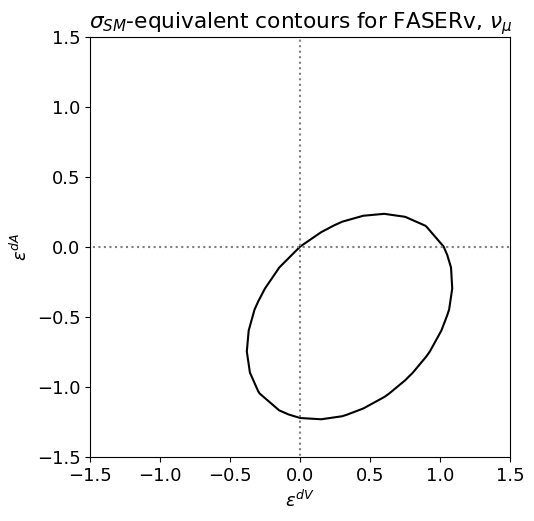

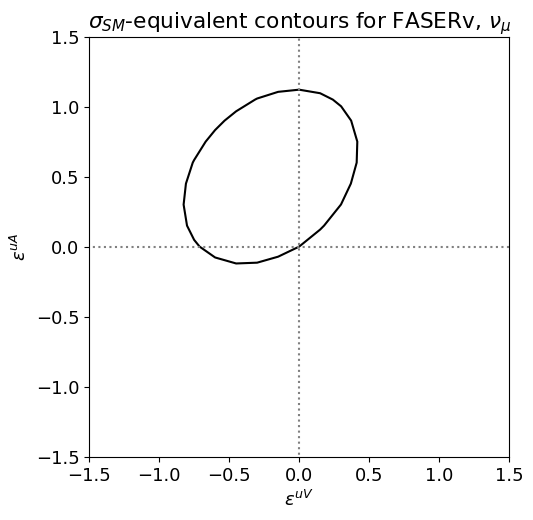

In [17]:
for q in ['d','u']:
    SMequivContourGrid(detector='FASERv',vpid='14',q=q)

## Defining the Model

We now define a `model()` which has model parameters $\lambda$ corresponding to how much to steer into the min/max variation directions from the central prediction. The min/max variations are assigne when writing the JSONs: they correspond to either dedicated flux files (`simplevar` $=$ `False`), or a simple multiplication/division by 2, depending on whether the global (`simplevar` $=$ `True`).
The various parent hadrons (or classes of them) have dedicated weights $\lambda$. 
The JSONs contain fit parameters for each bin; from these, an 1D polynomial is reconstructed here for retrieving the number of events per bin.

The model then reduces to the central prediction when 
$\lambda_p = 0~\forall p$, 
while 
$\lambda_p = 1~\forall p$ 
returns the max variation and
$\lambda_p = -1~\forall p$ 
the min variation.

In [18]:
#Param
#  detector   Name of the detector, e.g. "FASERv"
#  radN       Tag indicating number of radial bins, e.g. '_rad1'
#  lambdamat  Matrix of lambda parameter values
#  fstat      A constant factor to globally increase or decrease statistics
#  usevpids   List vpids (str) to use, enables forcing CID different from detector defaults
#  modelpars  A dictionary of additional parameters's names and values, for including e.g. NSI Wilson coefficients
#Returns a data object containing the histograms of incoming and interacting neutrinos per neutrino ID
def model(detector,radN='_rad1',lambdamat=deepcopy(lambdaBL),fstat=1.0,\
          useorigins=origins,usevpids=[],modelpars={},genpair=genpairBL):

    global vpids
    
    NSIgrid=True  #True: use NSIxsec grid, False: brute force (not recommended)
    
    #Load data
    #N.B. current implementation is for one generator pair only
    dataJ = load_json(fitspectratag+genpair['light']+'_'+genpair['charm']+'_'+detector+radN)
        
    #Ensure no dimension mismatch
    #N.B. Current implementation intended for 1 generator pair, but any generalization involving combining several generators or
    #     interpolating between max/central/min variations would be included in this function.
    #     The model won't be generator amount dependent here.
    for i,lvec in enumerate(lambdamat):
        if len(lvec)!=(Ngp[i]-BLdimRed):
            print("ERROR #lambdas for particle type="+str(len(lvec))+" =/= #generators-1="+str(Ngp[i]-BLdimRed))
            sys.exit()

    #Initially perform the computations assuming all vpids, ensures e.g. using the right Wilson coefficients per vpid 
    vpidall = [str(vpid) for vpid in list(vpids.keys())]
    
    #Numbers of incoming neutrinos and interactions
    n_nu, n_cc, n_nc = {}, {}, {}
    for vpid in vpidall:
        #Numbers per neutrino flavor and origin
        n_nu[vpid], n_cc[vpid], n_nc[vpid] = {}, {}, {}
        for iorig,orig in enumerate(useorigins):
            n_nu[vpid][orig] = np.array(dataJ[vpid][orig]['n_nu'])
            n_cc[vpid][orig] = np.array(dataJ[vpid][orig]['n_cc'])
            n_nc[vpid][orig] = np.array(dataJ[vpid][orig]['n_nc'])
    
    #If at least one NSI parameter found in modelpars
    #Relevant modelpars entries have keys of the form 'epsuA_ee', 'epsdV_mumu', etc.
    if sum(['eps' in modelpar for modelpar in modelpars]) > 0:
        for vpid in vpidall:
            
            llstr='ee'  #Nu flavor indicator string
            if   abs(int(vpid))==14: llstr='mumu'
            elif abs(int(vpid))==16: llstr='tautau'
            SMxs =np.zeros(len(dataJ[vpid][list(origins.keys())[0]]['ebins'])-1)  #Init xsec to zero arrays
            NSIxs=np.zeros(len(dataJ[vpid][list(origins.keys())[0]]['ebins'])-1)
            
            #Sum cross section contributions over quark flavors
            for iq,q in enumerate(['d','u','s','c','b','t']): #Check all flavors, though current study is for d,u
                epsVval,epsAval = 0.,0.
                #Only compute cases corresponding to requested Wilson coefficient
                if 'eps'+q+'V_'+llstr not in modelpars and 'eps'+q+'A_'+llstr not in modelpars: continue
                if 'eps'+q+'V_'+llstr in modelpars: epsVval=modelpars['eps'+q+'V_'+llstr]
                if 'eps'+q+'A_'+llstr in modelpars: epsAval=modelpars['eps'+q+'A_'+llstr]
                SMxs  = np.add(SMxs, get_sigmaNSI(detector=detector,vpid=vpid,q=q,epsVval=0,epsAval=0))
                NSIxs = np.add(NSIxs,get_sigmaNSI(detector=detector,vpid=vpid,q=q,epsVval=epsVval,epsAval=epsAval))
            
            #Multiply each E-bin by the NSI/SM xsec ratio to estimate number of events w/ NSI
            for orig in n_nc[vpid]:
                for i in range(len(n_nc[vpid][orig])):
                    for j in range(len(n_nc[vpid][orig][i])):
                        NSIratio = 1.0 if SMxs[i]<=0 else NSIxs[i]/SMxs[i]
                        n_nc[vpid][orig][i][j] = n_nc[vpid][orig][i][j]*NSIratio
    
    #For the return object, check which neutrino IDs this model should include
    vpidlim = detectorvpidstrs(detector) if len(usevpids)==0 else usevpids
    
    #Sum up different origins' contributions and apply detection side factors
    #A new return object data is initiated (instead of appending dataJ and returning that) in order to avoid
    #passing a computation anything read from a JSON file that is not explicitly included here.
    data = {}
    for vpid in vpidlim:
        data[vpid]={}
        #Store energy and radial bin info to data object
        data[vpid]['ebins'] = dataJ[vpid][list(origins.keys())[0]]['ebins']
        data[vpid]['rbins'] = dataJ[vpid][list(origins.keys())[0]]['rbins']
        #Form basis of spectra for data objects by summing over neutrino parent hadrons
        data[vpid]['n_nu'] = sum([n_nu[vpid][orig] for orig in list(n_nu[vpid].keys())])
        data[vpid]['n_cc'] = sum([n_cc[vpid][orig] for orig in list(n_cc[vpid].keys())])
        data[vpid]['n_nc'] = sum([n_nc[vpid][orig] for orig in list(n_nc[vpid].keys())])
        avpid = '-'+vpid
        #If no CID available in the detector, or spefically requested, sum nu and nubar contributions
        if avpid in vpidall and avpid not in vpidlim:
            data[vpid]['n_nu']=np.add(sum([n_nu[avpid][orig] for orig in list(n_nu[vpid].keys())]),np.array(data[vpid]['n_nu']))
            data[vpid]['n_cc']=np.add(sum([n_cc[avpid][orig] for orig in list(n_cc[vpid].keys())]),np.array(data[vpid]['n_cc']))
            data[vpid]['n_nc']=np.add(sum([n_nc[avpid][orig] for orig in list(n_nc[vpid].keys())]),np.array(data[vpid]['n_nc']))
    
    #Apply factors to <in/de>crease statistics if requested
    for vpid in data:
        for n_x in ['n_nu','n_cc','n_nc']:
            data[vpid][n_x] = np.multiply(fstat,data[vpid][n_x])
    
    return data

### Quick checks of model properties

In [19]:
for detector in detectors:
    print('\n'+detector)
    modelobj = model(detector=detector,radN='_rad1') #,modelpars={'epsuV_mumu':1.0})
    for proc in ['n_cc','n_nc']:
        print(proc)
        for vpid in list(modelobj.keys()):
            print('For nuid '+vpid+': ',sum(list(modelobj[vpid][proc]))[0])


FASERv
n_cc
For nuid 12:  5031.339215141118
For nuid 14:  17715.94183311427
For nuid -14:  4657.942168011615
For nuid 16:  121.44044796877887
n_nc
For nuid 12:  1603.5531313942477
For nuid 14:  5210.652842915608
For nuid -14:  1674.6460245368391
For nuid 16:  41.27181771504531

FASER-PS
n_cc
For nuid 12:  19.36188355110634
For nuid -12:  13.004889207098095
For nuid 14:  110.07700084511309
For nuid -14:  32.09032105078086
n_nc
For nuid 12:  6.057401505963917
For nuid -12:  4.524766653150404
For nuid 14:  34.46158198102775
For nuid -14:  11.20963619450249

FASERv2
n_cc
For nuid 12:  218950.44709856933
For nuid 14:  775467.470060227
For nuid -14:  205585.14142290698
For nuid 16:  5490.8287830123545
n_nc
For nuid 12:  69716.17631429236
For nuid 14:  228020.23841594602
For nuid -14:  73894.1491780337
For nuid 16:  1868.051464447635

FASER2-PS
n_cc
For nuid 12:  185.36759641515505
For nuid -12:  110.54901575562447
For nuid 14:  989.1154316231704
For nuid -14:  287.5362501310729
n_nc
For nui

In [20]:
#It is also possible to force non-default CID properties
for detector in [detectors[0]]:
    print('\n'+detector+', perfect CID')
    modelobj = model(detector=detector,radN='_rad1',usevpids=[str(vpid) for vpid in vpids])
    for proc in ['n_cc','n_nc']:
        print(proc)
        for vpid in list(modelobj.keys()):
            print('For nuid '+vpid+': ',sum(list(modelobj[vpid][proc]))[0])


FASERv, perfect CID
n_cc
For nuid 12:  3231.5603742962885
For nuid -12:  1799.7788408448287
For nuid 14:  17715.94183311427
For nuid -14:  4657.942168011615
For nuid 16:  87.95648919570215
For nuid -16:  33.48395877307671
n_nc
For nuid 12:  953.4964345896731
For nuid -12:  650.0566968045748
For nuid 14:  5210.652842915608
For nuid -14:  1674.6460245368391
For nuid 16:  27.956854129492662
For nuid -16:  13.314963585552652


In [21]:
#Numbers of interactions from each particle type
for detector in [detectors[0]]: #detectors:
    print('\n'+detector)
    for proc in ['n_cc','n_nc']:
        print(proc)
        for origin in origins:
            modelobj = model(detector=detector,radN='_rad1',useorigins=[origin])
            print(origin)
            for vpid in list(modelobj.keys()):
                print('For nuid '+vpid+': ',sum(list(modelobj[vpid][proc]))[0])


FASERv
n_cc
pi+
For nuid 12:  2.65372974377878
For nuid 14:  7283.887744484827
For nuid -14:  0.0
For nuid 16:  0.0
pi-
For nuid 12:  0.7488725756140593
For nuid 14:  0.0
For nuid -14:  2079.8157988522607
For nuid 16:  0.0
K+
For nuid 12:  360.3615162745857
For nuid 14:  8270.002168271552
For nuid -14:  0.0
For nuid 16:  0.0
K-
For nuid 12:  73.68668803384698
For nuid 14:  0.0
For nuid -14:  1650.1526491209072
For nuid 16:  0.0
K0
For nuid 12:  2505.4352232142746
For nuid 14:  1048.5073425895462
For nuid -14:  469.65358164337357
For nuid 16:  0.0
Lambda0
For nuid 12:  490.4802983590034
For nuid 14:  0.0
For nuid -14:  45.98296779512365
For nuid 16:  0.0
Lambda0bar
For nuid 12:  20.903515322297753
For nuid 14:  2.1175973117544413
For nuid -14:  0.0
For nuid 16:  0.0
D0
For nuid 12:  339.22537558205335
For nuid 14:  315.1971852789219
For nuid -14:  0.0
For nuid 16:  0.0
D0bar
For nuid 12:  168.23816630033696
For nuid 14:  0.0
For nuid -14:  162.051401606874
For nuid 16:  0.0
D+
For nuid

### Constraining forward hyperon production

Since the charged kaon and $D_s$ contributions to the $\nu_e+\overline{\nu}_e$ spectrum can be assumed to be constrained perfectly, 
the predominant contributions to the remainder are neutral kaons and hyperons $\Lambda_0$. The hyperon decays result in antineutrinos, while kaons can produce both equally. Therefore, in a detector with electron charge identification capapbilities, the difference $\overline{\nu}_e-\nu_e$ is a handle for constraining the number of neutrinos originating from hyperon decays. Note that this is applicable in the energy regime of FASER(2), but not expected to hold at very high $E_\nu$.

Although other contributions are practically negligible at the energies relevant to FASER(2), the following contributions are included for completeness when obtaining the total unconstrained $\nu_e+\overline{\nu}_e$ spectrum:

In [22]:
unconstrhad = ['pi+','pi-',\
               #'K+','K-',\
               'K0',\
               'D0','D0bar',
               'D+','D-',\
               #'Ds+','Ds-',\
               'Lambdac+',\
               'Lambda0','Lambda0bar']

Now plot $E_\nu$ (logarithmically) vs $dN/d\log(E_\nu) = E\nu dN/dE_\nu$ distributions for the $\nu_e+\overline{\nu}_e$, $\nu_e$, $\overline{\nu}_e$ and $\overline{\nu}_e-\nu_e$. 
The last one is compared to the Monte Carlo truth level hyperon event spectrum, and the uncertainties for it are obtained as a quadratic sum of the uncertainties of the individual $\nu_e$ and $\overline{\nu}_e$ spectra, through the statistical uncertainty of the observed CC interactions associated with the respective neutrino.

The function `NLambda` returns two numbers, corresponding to the ratio of $\Lambda_0$ contributions to the unconstrained $\nu_e+\overline{\nu}_e$ spectrum, assuming either the lower or upper uncertainties on the $\overline{\nu}_e-\nu_e$ spectrum. 
These ratios are used below as weights to hyperon-only (kaon-only) spectra to obtain uncertainty bands: the idea is that complete ignorance of the number of hyperon events suggests that the unconstrained contribution to the $\nu_e+\overline{\nu}_e$ spectrum could in principle come entirely from hyperons, or entirely from neutral kaons ("hyperon-only" and "kaon-only" spectra). These spectra give maximally different shapes to each other, but can be normalized to the same number of observed CC events, and the envelope between the spectra determines the uncertainty of the electron neutrino spectra. Once a measurement of the number of hyperon events is introduced, the spectra are replaced by linear combinations of the hyperon-only and kaon-only spectra, with weights corresponding to the lower and upper limit on the number of hyperons. Note that in principle $\overline{\nu}_e-\nu_e$ can have negative values due to other effects than the hyperon contribution, but here the returned uncertainties are bounded from below by 0 to be identifiable with the number of hyperons.

In [23]:
def NLambda(detector,genpair=genpairBL):
    global codename
    global lambdaBL
    global unconstrhad
    filename='plots/'+detector+'_NLambda.pdf'

    #Setup figure
    matplotlib.rcParams.update({'font.size': 14})
    matplotlib.rcParams.update({'legend.fontsize': 'medium'})
    matplotlib.rcParams.update({'axes.labelsize': 'large'})
    matplotlib.rcParams.update({'axes.titlesize':'large'})
    matplotlib.rcParams.update({'xtick.labelsize':'large'})
    matplotlib.rcParams.update({'ytick.labelsize':'large'})
    matplotlib.rcParams['text.usetex'] = False
    fig = plt.figure(figsize=(8,5))
    ax11 = fig.add_axes([0.11, 0.13, 0.89, 0.86], xticklabels=[], )
    axes =  np.array([[ax11]])
    fscale,fscalestr = 1e-12,' [$10^{12}$ neutrinos]'  #Scale 
    
    #Model objects for considering all origin hadrons, only hyperons or the ones not constrained elsewhere
    #by subtracting hyperon contributions from all-origin spectra
    mLambda0 = model(detector=detector,radN='_rad1',lambdamat=deepcopy(lambdaBL),genpair=genpair,
                       useorigins=['Lambda0'])#,'Lambda0bar'])
    mtot = model(detector=detector,radN='_rad1',lambdamat=deepcopy(lambdaBL),genpair=genpair,useorigins=unconstrhad)
    #Fetch bin information
    vpidstrs = list(mtot.keys())
    ebins = np.array(mtot[vpidstrs[0]]['ebins'])
    ebinw = np.array([0.5*(ebins[i+1]-ebins[i]) for i in range(len(ebins)-1)])
    ecenters = (ebins[1:]+ebins[:-1])/2
    ebinw = np.array([0.5*(ebins[i+1]-ebins[i]) for i in range(len(ebins)-1)])
    Elims=[20,5000]  #Also used below for horizontal axis limits
    efine = np.logspace(np.log10(Elims[0]),np.log10(Elims[1]),31)  #For plotting smooth interpolation functions
    
    #Coarser bins for the histos representing data
    coarsef = 4 if '2' in detector else 6  #Make histos coarser by this factor
    skipstart = True  #If number of bins not divisible by factor, omit first bins instead of last bins
    idrop = [1,-2] if '2' in detector else [2,-2]  #Drop one or two [low-E,high-E] bins from the coarsed vectors, "not used in measurement"
    ecenterscoarse = xcoarser(ecenters, factor=coarsef, skipstart=True)[idrop[0]:idrop[1]]
    ebinwcoarse = sumcoarser(ebinw,coarsef,skipstart)[idrop[0]:idrop[1]]
        
    #Fetch model result projection, store different nu flavor contributions to "entries"
    nmax = 0.1  #tmp init
    entries=[]
    for vpid in ['12']:  #Plot nubare/nue only
        if '-' in vpid: continue                 #Loop only positive nuid
        elif not '-'+vpid in vpidstrs: continue  #Don't plot ratio if both + and - nuid don't exist

        #Estimate the specra of incoming (anti)neutrinos from observed numbers of nu and nubar        
        #nu
        Nnu   = np.array(mtot[vpid]['n_nu']).T[0]
        NnuCC = np.array(mtot[vpid]['n_cc']).T[0]
        Nnucoarse   = sumcoarser(Nnu,  factor=coarsef,skipstart=skipstart)[idrop[0]:idrop[1]]
        NnuCCcoarse = sumcoarser(NnuCC,factor=coarsef,skipstart=skipstart)[idrop[0]:idrop[1]]
        Nnucoarse2E = np.divide(Nnucoarse,ebinwcoarse)         #"2E" = Divide by bin width
        Nnustat   = np.divide(Nnucoarse,np.sqrt(NnuCCcoarse))  #Stat unc from n.o. obs. interactions, norm. to n_nu
        Nnustat2E = np.divide(np.divide(Nnucoarse,np.sqrt(NnuCCcoarse)),ebinwcoarse)
        #nubar
        Nnubar   = np.array(mtot['-'+vpid]['n_nu']).T[0]
        NnubarCC = np.array(mtot['-'+vpid]['n_cc']).T[0]
        Nnubarcoarse   = sumcoarser(Nnubar,  factor=coarsef,skipstart=skipstart)[idrop[0]:idrop[1]]
        NnubarCCcoarse = sumcoarser(NnubarCC,factor=coarsef,skipstart=skipstart)[idrop[0]:idrop[1]]
        Nnubarcoarse2E = np.divide(Nnubarcoarse,ebinwcoarse)
        Nnubarstat   = np.divide(Nnubarcoarse,np.sqrt(NnubarCCcoarse))  #Stat unc from n.o. obs. interactions, norm. to n_nu
        Nnubarstat2E = np.divide(Nnubarstat,ebinwcoarse)
        #nubar-nu. For stat unc, sum nu and nubar stat unc in quadrature
        NnubarSubNnucoarse   = np.subtract(Nnubarcoarse,  Nnucoarse)
        NnubarSubNnucoarse2E = np.subtract(Nnubarcoarse2E,Nnucoarse2E)
        NnubarSubNnustat     = np.sqrt(np.add(np.power(Nnustat,  2),np.power(Nnubarstat,  2)))
        NnubarSubNnustat2E   = np.sqrt(np.add(np.power(Nnustat2E,2),np.power(Nnubarstat2E,2)))

        #Plot nubar+nu
        nubarPnuvals = np.multiply(ecenters,np.add(np.divide(Nnubar,ebinw),np.divide(Nnu,ebinw)))
        axes[0,0].plot(efine,np.multiply(fscale,np.interp(efine,ecenters,nubarPnuvals)),\
                       label=r'Unconstr. $\bar\nu_e+\nu_e$',color='gray', linestyle='dashdot', linewidth=1.5)
        nmax = max(fscale*max(nubarPnuvals),nmax)
                
        #Plot nubar
        axes[0,0].plot(efine,np.multiply(fscale,np.interp(efine,ecenters,np.multiply(ecenters,np.divide(Nnubar,ebinw)))),\
                       label=r'$\bar\nu_e$',color='dodgerblue', linestyle=(0, (5, 7)), linewidth=1.7)
        
        #Plot nu
        axes[0,0].plot(efine,np.multiply(fscale,np.interp(efine,ecenters,np.multiply(ecenters,np.divide(Nnu,ebinw)))),\
                       label=r'$\nu_e$', color='purple', linestyle='dotted', linewidth=1.7)
        
        #Plot nubar-nu
        axes[0,0].errorbar(x=ecenterscoarse,
                           y=np.multiply(fscale,np.multiply(ecenterscoarse,NnubarSubNnucoarse2E)),\
                           xerr=ebinwcoarse,\
                           yerr=np.multiply(fscale,np.multiply(ecenterscoarse,NnubarSubNnustat2E)),\
                           color='black',\
                           linewidth=0.,\
                           elinewidth=1.,\
                           capsize=5)
        axes[0,0].plot(efine,np.multiply(fscale,np.interp(efine,ecenters,np.multiply(ecenters,np.subtract(np.divide(Nnubar,ebinw),\
                                                                                                          np.divide(Nnu,   ebinw))))),\
                       label=r'$\bar\nu_e-\nu_e$',color='black', linestyle='dashed', linewidth=1.5)

        #The error estimate return value. The below gives simply fractions of the location of the upper and lower error bar 
        #(latter replaced by zero where negative). Note that factors/divisions of ecenterscoarse, 2E, ebinwcoarse, fscale cancel in ratio.
        #Start by varying nubar-nu down and up by the uncertainties
        ret = {'lo': np.subtract(NnubarSubNnucoarse,NnubarSubNnustat),\
               'cn': NnubarSubNnucoarse,\
               'hi': np.add(     NnubarSubNnucoarse,NnubarSubNnustat)}
        #Total n.o. events for computing ratios
        NnubarAddNnu = np.add(Nnubarcoarse, Nnucoarse)
        for key in ret:
            #Reset negative values to 0, they cannot be identified w/ a number of hyperons, but are due to other effects
            ret[key] = np.max([ret[key],[0. for _ in ret[key]]],axis=0)        
            #Obtain ratio
            ret[key] = sum(np.multiply(ebinwcoarse,ret[key]))/sum(np.multiply(ebinwcoarse,NnubarAddNnu))
        
        #Plot expected hyperon contributions directly
        NLambda0 = np.add(np.array(mLambda0[vpid]['n_nu']).T[0], np.array(mLambda0['-'+vpid]['n_nu']).T[0])
        axes[0,0].plot(efine,np.multiply(fscale,np.interp(efine,ecenters,np.multiply(ecenters,np.divide(NLambda0,ebinw)))),\
                       color='red', linestyle='solid',linewidth=1.5,\
                       label=r'$\overline{\nu}_e$ from $\Lambda_0$')
        
    #Further plotstyle setup
    axes[0,0].set_xlabel(r'$E_\nu$ [GeV]')
    ylims=[-0.1*nmax,1.1*nmax]
    axes[0,0].set_ylabel(r'$E_\nu$ $dN/dE_\nu$'+fscalestr)
    ymin,ymax = axes[0,0].get_ylim()
    xrunstr,runstr = 1.5e3,' at Run 4'
    if experiments[detector]['lumi']==3000: xrunstr,runstr = 1.2e3,' at HL-LHC'
    axes[0,0].text(xrunstr, 0.99*(ymax-ymin)+ymin, detector.split('-')[0]+runstr)
    axes[0,0].set_xscale("log")
    axes[0,0].set_ylim(ylims)
    axes[0,0].set_xlim(Elims)
    matplotlib.rcParams.update({'legend.loc':'upper left'})
    axes[0,0].legend(frameon=False,fontsize=14)    
    
    #finalize figure
    if filename is not None: 
        plt.savefig(filename)
        print('Saved ',filename)
    plt.show()
    return ret

Saved  plots/FASER-PS_NLambda.pdf


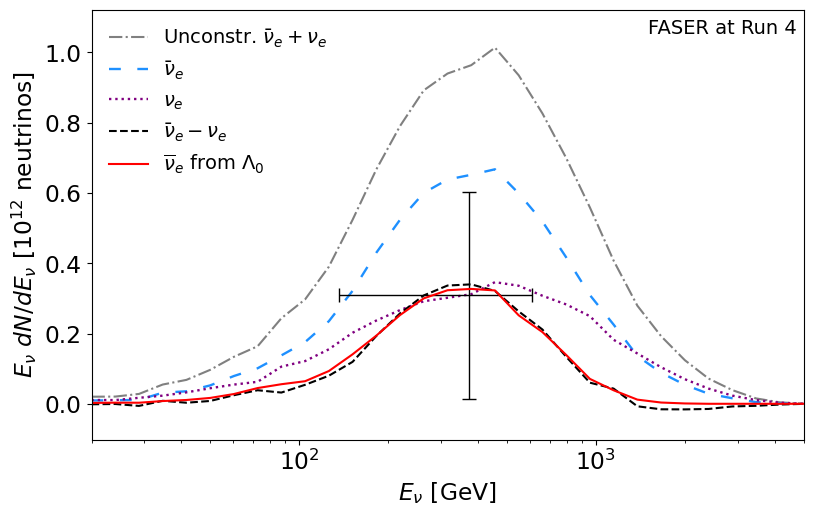

Saved  plots/FASER2-PS_NLambda.pdf


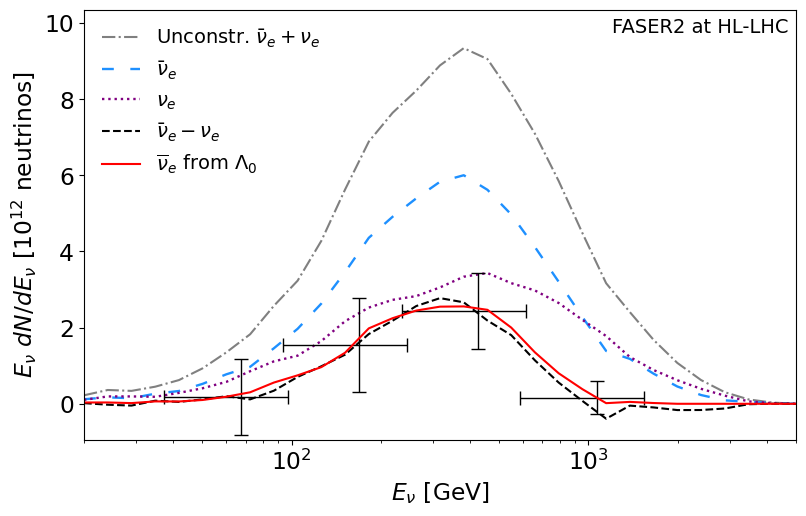

Hyperon ratio estimate:
FASER-PS {'lo': np.float64(0.014886123084015879), 'cn': np.float64(0.32306977754806826), 'hi': np.float64(0.6312534320121206)}
FASER2-PS {'lo': np.float64(0.06949599442454998), 'cn': np.float64(0.15516163328225252), 'hi': np.float64(0.27765627794356446)}


In [24]:
Lambda0ratio={}
for detector in ['FASER-PS','FASER2-PS']:
    Lambda0ratio[detector] = NLambda(detector=detector,genpair=genpairBL)
print('Hyperon ratio estimate:')
for key in Lambda0ratio: print(key,Lambda0ratio[key])

In [25]:
#Produce a similar plot but vertical axis multiplied by E^2 instead of E
def NLambdaE2(detector,genpair=genpairBL):
    global codename
    global lambdaBL
    global unconstrhad
    filename='plots/'+detector+'_NLambda_E2.pdf'

    #Setup figure
    matplotlib.rcParams.update({'font.size': 14})
    matplotlib.rcParams.update({'legend.fontsize': 'medium'})
    matplotlib.rcParams.update({'axes.labelsize': 'large'})
    matplotlib.rcParams.update({'axes.titlesize':'large'})
    matplotlib.rcParams.update({'xtick.labelsize':'large'})
    matplotlib.rcParams.update({'ytick.labelsize':'large'})
    matplotlib.rcParams['text.usetex'] = False
    fig = plt.figure(figsize=(8,5))
    ax11 = fig.add_axes([0.11, 0.13, 0.88, 0.86], xticklabels=[], )
    axes =  np.array([[ax11]])
    fscale,fscalestr = 1e-15,' [$10^{15}$ GeV]'  #Scale 
    
    #Model objects for considering all origin hadrons, only hyperons or the ones not constrained elsewhere
    #by subtracting hyperon contributions from all-origin spectra
    mLambda0 = model(detector=detector,radN='_rad1',lambdamat=deepcopy(lambdaBL),genpair=genpair,
                       useorigins=['Lambda0'])#,'Lambda0bar'])
    mtot = model(detector=detector,radN='_rad1',lambdamat=deepcopy(lambdaBL),genpair=genpair,useorigins=unconstrhad)
    #Fetch bin information
    vpidstrs = list(mtot.keys())
    ebins = np.array(mtot[vpidstrs[0]]['ebins'])
    ebinw = np.array([0.5*(ebins[i+1]-ebins[i]) for i in range(len(ebins)-1)])
    ecenters = (ebins[1:]+ebins[:-1])/2
    ecenters2 = np.power(ecenters,2)
    ebinw = np.array([0.5*(ebins[i+1]-ebins[i]) for i in range(len(ebins)-1)])
    Elims=[20,5000]  #Also used below for horizontal axis limits
    efine = np.logspace(np.log10(Elims[0]),np.log10(Elims[1]),31)  #For plotting smooth interpolation functions
    
    #Coarser bins for the histos representing data
    coarsef = 4 if '2' in detector else 6  #Make histos coarser by this factor
    skipstart = True  #If number of bins not divisible by factor, omit first bins instead of last bins
    idrop = [1,-2] if '2' in detector else [2,-2]  #Drop one or two [low-E,high-E] bins from the data plots
    ecenterscoarse = xcoarser(ecenters,  factor=coarsef, skipstart=True)[idrop[0]:idrop[1]]
    ecenterscoarse2 = np.power(ecenterscoarse,2)
    ebinwcoarse = sumcoarser(ebinw,coarsef,skipstart)[idrop[0]:idrop[1]]
        
    #Fetch model result projection, store different nu flavor contributions to "entries"
    nmax = 0.1  #tmp init
    entries=[]
    for vpid in ['12']:  #Plot nubare/nue only
        if '-' in vpid: continue                 #Loop only positive nuid
        elif not '-'+vpid in vpidstrs: continue  #Don't plot ratio if both + and - nuid don't exist

        #Estimate the specra of incoming (anti)neutrinos from observed numbers of nu and nubar        
        #nu
        Nnu   = np.array(mtot[vpid]['n_nu']).T[0]
        NnuCC = np.array(mtot[vpid]['n_cc']).T[0]
        Nnucoarse   = sumcoarser(Nnu,  factor=coarsef,skipstart=skipstart)[idrop[0]:idrop[1]]
        NnuCCcoarse = sumcoarser(NnuCC,factor=coarsef,skipstart=skipstart)[idrop[0]:idrop[1]]
        Nnucoarse2E = np.divide(Nnucoarse,ebinwcoarse)         #"2E" = Divide by bin width
        Nnustat   = np.divide(Nnucoarse,np.sqrt(NnuCCcoarse))  #Stat unc from n.o. obs. interactions, norm. to n_nu
        Nnustat2E = np.divide(np.divide(Nnucoarse,np.sqrt(NnuCCcoarse)),ebinwcoarse)
        #nubar
        Nnubar   = np.array(mtot['-'+vpid]['n_nu']).T[0]
        NnubarCC = np.array(mtot['-'+vpid]['n_cc']).T[0]
        Nnubarcoarse   = sumcoarser(Nnubar,  factor=coarsef,skipstart=skipstart)[idrop[0]:idrop[1]]
        NnubarCCcoarse = sumcoarser(NnubarCC,factor=coarsef,skipstart=skipstart)[idrop[0]:idrop[1]]
        Nnubarcoarse2E = np.divide(Nnubarcoarse,ebinwcoarse)
        Nnubarstat   = np.divide(Nnubarcoarse,np.sqrt(NnubarCCcoarse))  #Stat unc from n.o. obs. interactions, norm. to n_nu
        Nnubarstat2E = np.divide(np.divide(Nnubarcoarse,np.sqrt(NnubarCCcoarse)),ebinwcoarse)
        #nubar-nu. For stat unc, sum nu and nubar stat unc in quadrature
        NnubarSubNnustat   = np.sqrt(np.add(np.power(Nnustat,  2),np.power(Nnubarstat,  2)))
        NnubarSubNnustat2E = np.sqrt(np.add(np.power(Nnustat2E,2),np.power(Nnubarstat2E,2)))

        #Plot nubar+nu
        nubarPnuvals = np.multiply(ecenters2,np.add(np.divide(Nnubar,ebinw),np.divide(Nnu,ebinw)))
        axes[0,0].plot(efine,np.multiply(fscale,np.interp(efine,ecenters,nubarPnuvals)),\
                       label=r'Unconstr. $\bar\nu_e+\nu_e$',color='gray', linestyle='dashdot', linewidth=1.5)
        nmax = max(fscale*max(nubarPnuvals),nmax)
                
        #Plot nubar
        axes[0,0].plot(efine,np.multiply(fscale,np.interp(efine,ecenters,np.multiply(ecenters2,np.divide(Nnubar,ebinw)))),\
                       label=r'$\bar\nu_e$',color='dodgerblue', linestyle=(0, (5, 7)), linewidth=1.7)
        
        #Plot nu
        axes[0,0].plot(efine,np.multiply(fscale,np.interp(efine,ecenters,np.multiply(ecenters2,np.divide(Nnu,ebinw)))),\
                       label=r'$\nu_e$', color='purple', linestyle='dotted', linewidth=1.7)
        
        #Plot nubar-nu
        axes[0,0].errorbar(x=ecenterscoarse,
                           y=np.multiply(fscale,np.multiply(ecenterscoarse2,np.subtract(Nnubarcoarse2E,Nnucoarse2E))),\
                           xerr=ebinwcoarse,\
                           yerr=np.multiply(fscale,np.multiply(ecenterscoarse2,NnubarSubNnustat2E)),\
                           color='black',\
                           linewidth=0.,\
                           elinewidth=1.,\
                           capsize=5)
        axes[0,0].plot(efine,np.multiply(fscale,np.interp(efine,ecenters,np.multiply(ecenters2,np.subtract(np.divide(Nnubar,ebinw),\
                                                                                                           np.divide(Nnu,   ebinw))))),\
                       label=r'$\bar\nu_e-\nu_e$',color='black', linestyle='dashed', linewidth=1.5)
        
        #Plot expected hyperon contributions directly
        NLambda0 = np.add(np.array(mLambda0[vpid]['n_nu']).T[0], np.array(mLambda0['-'+vpid]['n_nu']).T[0])
        axes[0,0].plot(efine,np.multiply(fscale,np.interp(efine,ecenters,np.multiply(ecenters2,np.divide(NLambda0,ebinw)))),\
                       color='red', linestyle='solid',linewidth=1.5,\
                       label=r'$\overline{\nu}_e$ from $\Lambda_0$')
        
    #Further plotstyle setup
    axes[0,0].set_xlabel(r'$E_\nu$ [GeV]')
    ylims=[-0.1*nmax,1.1*nmax]
    axes[0,0].set_ylabel(r'$E_\nu^2$ $dN/dE_\nu$'+fscalestr)
    ymin,ymax = axes[0,0].get_ylim()
    xrunstr,runstr = 1.9e3,' at Run 4'
    if experiments[detector]['lumi']==3000: xrunstr,runstr = 1.6e3,' at HL-LHC'
    axes[0,0].text(xrunstr, 0.99*(ymax-ymin)+ymin, detector.split('-')[0]+runstr)
    axes[0,0].set_xscale("log")
    axes[0,0].set_ylim(ylims)
    axes[0,0].set_xlim([60,Elims[-1]])
    matplotlib.rcParams.update({'legend.loc':'upper left'})
    axes[0,0].legend(frameon=False,fontsize=14)    
    
    #finalize figure
    if filename is not None: 
        plt.savefig(filename)
        print('Saved ',filename)
    plt.show()

Saved  plots/FASER-PS_NLambda_E2.pdf


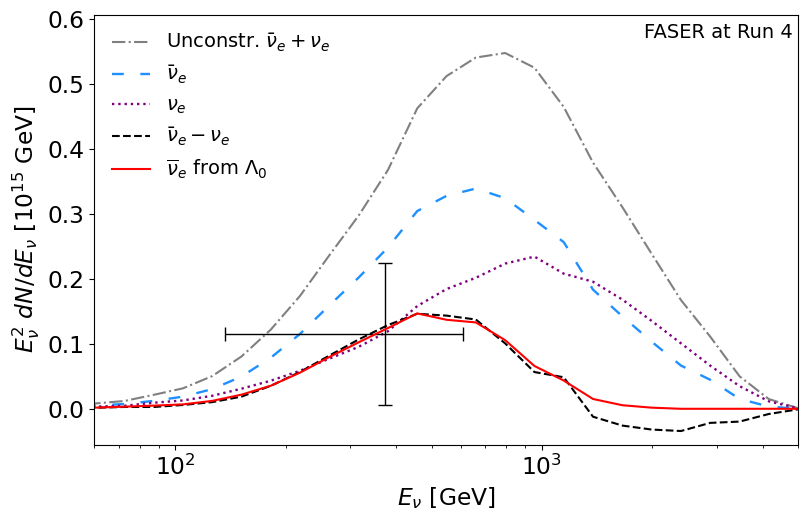

Saved  plots/FASER2-PS_NLambda_E2.pdf


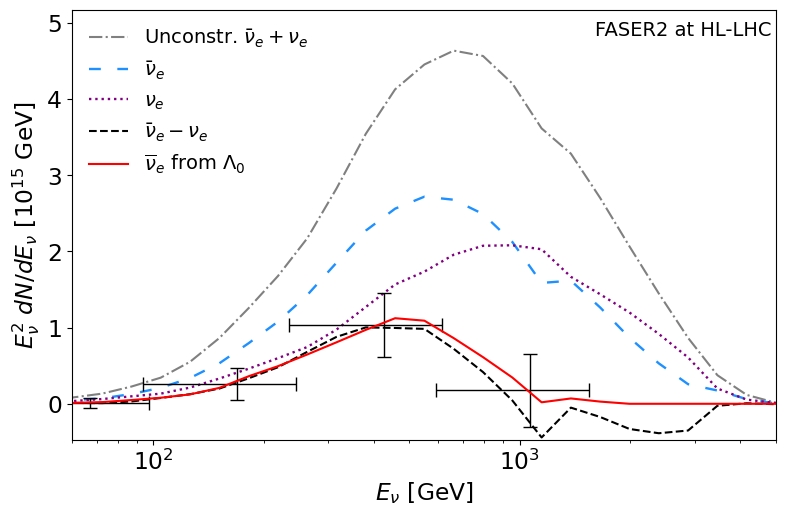

In [26]:
for detector in ['FASER-PS','FASER2-PS']:
    NLambdaE2(detector=detector,genpair=genpairBL)

### Physics driven systematic uncertainty estimates

To obtain an estimate for systematic uncertainties on the electron neutrino spectrum, the total number of $\nu_e+\bar{\nu}_e$ CC interactions is assumed to be perfectly constrained, and from these CC event statistics the incoming neutrino flux is deduced. 
However, most importantly, the difference $\overline{\nu}_e - \nu_e$ is unknown. 

The dominant contributions to the unconstrained part of the $\overline{\nu}_e - \nu_e$ spectrum are neutral kaons and hyperons, and assuming $\nu_e$ and \$\overline{\nu}_e$ are coming only from one or the other of them should yield two extrema of different $\nu_e$ and $\overline{\nu}_e$ spectrum shapes. This will be taken as an estimate of systematic uncertainty for the electron neutrino spectrum, when there is no PS available in the detector setup, and hence no electron charge identification capability.

The hyperon-only and kaon-only spectra, as well as any interpolation between them, are normalized by requiring that the total number of their $\nu_e+\overline{\nu}_e$ CC events equals that of assuming all the unconstrained origins in the baseline (SIBYLL+POWHEG) calculation. The same scaling factors required for this normalization are then applied to the models's spectra of NC interactions (and that of incoming neutrinos). While this changes the normalization and shape of the spectrum of all incoming neutrinos, the changes to the spectra of NC interactions are observed to be less drastic, as shown and discussed below.

In [27]:
#AUX function to plot the extremal spectra in the no-PS case vs. the baseline prediction
def plotExtremalSpectra(detector,nrmlvl,retlvl,const,uncon,kaons,hprns,Hr):
    
    #Define the spectra to be plotted, and corresponding plot vertical axis labels
    nspecs = [['n_cc', r'$(\overline{\nu}_e+\nu_e)$CC interactions'],\
              ['n_nu', r'Incoming $\overline{\nu}+\nu$ (CC norm.)'],\
              ['n_nc', r'$\overline{\nu}+\nu$NC interactions (CC norm.)']]
    _,ecenters,_,_ = get_bins(detector)
    fig = plt.figure(figsize=(15,5))
    xstart,xw,xbf=0.12,0.24,0.06  #Where leftmost x axis starts, each plot width, buffer between plots
    axes = np.array([[fig.add_axes([xstart+i*(xw+xbf), 0.10, xw, 0.84], ) for i in range(len(nspecs))]])

    #Normalize hyperon and kaon contributions to all unconstrained CC interactions (nue+nuebar CC constrained perfectly)
    f_hprn_norm = sum(uncon[nrmlvl].T[0])/sum(hprns[nrmlvl].T[0])  #Normalization...
    f_kaon_norm = sum(uncon[nrmlvl].T[0])/sum(kaons[nrmlvl].T[0])  #...factors

    #Spectra where the unconstrained contribution is replaced by either all hyperons or all kaons
    lvls=['n_nu','n_cc','n_nc']
    Honly = {lvl: np.add(const[lvl].T[0], np.multiply(hprns[lvl].T[0],f_hprn_norm)) for lvl in lvls}
    Konly = {lvl: np.add(const[lvl].T[0], np.multiply(kaons[lvl].T[0],f_kaon_norm)) for lvl in lvls}
    
    basel = {lvl: np.array([np.add(np.multiply(Honly[lvl],Hr['cn']),np.multiply(Konly[lvl],np.subtract(1.,Hr['cn'])))]).T for lvl in lvls}
    
    #List the models to be plotted, and their plot options
    plotobjs = [{'model':hprns,'lstyle':'solid', 'lcolor':'dodgerblue','lbl':r'$\Lambda_0$ only','countlbl':r'$\Lambda_0$'},\
                {'model':uncon,'lstyle':'dashed','lcolor':'gray'      ,'lbl':r'All uncon.'      ,'countlbl':r'All'},\
                {'model':basel,'lstyle':'dashed','lcolor':'black'     ,'lbl':r'Baseline'        ,'countlbl':r'BL'},\
                {'model':kaons,'lstyle':'dotted','lcolor':'red'       ,'lbl':r'$K_0$ only'      ,'countlbl':r'$K_0$'}]
        
    #Plot
    for i,nspec in enumerate(nspecs):
        for j,plotobj in enumerate(plotobjs):
            #Assume total n.o. nue+nuebar CC constrained perfectly, normalize single-origin spectra to it    
            spectrum = plotobj['model'][nspec[0]].T[0]
            spectrum_norm = np.multiply(plotobj['model'][nspec[0]].T[0],sum(uncon[nrmlvl].T[0])/sum(plotobj['model'][nrmlvl].T[0]))
            axes[0,i].plot(ecenters,spectrum_norm,linestyle=plotobj['lstyle'], color=plotobj['lcolor'], label=plotobj['lbl'])
            axes[0,i].set_ylabel(nspec[1])
            axes[0,i].set_title('Unconstrained contrib. only')    
            #Write spectrum integrals on the plots
            ymin,ymax = axes[0,i].get_ylim()
            axes[0,i].text(10, (0.55+0.1*(j+0.4))*(ymax-ymin) + ymin,\
                           plotobj['countlbl']+': '+str(int(sum(spectrum))) )
            axes[0,i].text(10, (0.55+0.1*(j))*(ymax-ymin) + ymin,\
                           r' $\rightarrow$ '+str(int(sum(spectrum_norm)))+' (norm)' )
        axes[0,i].text(10, 0.95*(ymax-ymin)+ymin,'Integrals')
    
    #Plot style setup and save
    for i in range(len(axes[0])): axes[0,i].set_xscale("log")
    matplotlib.rcParams.update({'legend.loc':'lower left'})
    axes[0,0].legend(frameon=False,fontsize=14)
    filename = 'plots/extremalSpectra_'+detector+'.pdf'
    plt.savefig(filename)
    print('Saved',filename)

A detector without the capability for electron charge identification can only measure the $N(\overline{\nu}_e-\nu_e)$ spectrum, while a detector with it can also measure $\overline{\nu}_e-\nu_e$. As shown in the section above, the number of forward hyperons can be reliably identified with this difference in the energy regime relevant for FASER(2). This means that the systematic uncertainty for the electron neutrino spectrum in a detector setup including the PS (alongside the main detector) can be estimated from the upper/lower uncertainties on a measurement of the number of $\Lambda_0$: once this number is known, we can deduce the fraction of hyperon contributions to the spectrum, and the remainder must be due to kaons. The extremal spectra of the conservative uncertainty estimate without the PS are then replaced by spectra based on assuming the highest and lowest fractional hyperon contribution, and their envelope yields an asymmetric uncertainty on the $\nu_e$ spectrum.

Note that the hyperon ratio/fraction is estimated from FASER(2)-PS results (the main FASERv(2) detector does not give $\nu_e,\overline{\nu}_e$ info). However, the ratio is universal, and leads to better constraints on forward hadron production, which decreases the electron neutrino spectrum uncertainties also for the main detector.

In [28]:
#Param  detector     The detector for which the uncertainties should be computed
#       Hr           Dictionary containing 'lo': Lower bound on the (nuebar-nue)/(tot.unconstrained) ratio, 
#                    related to hyperons/(hyperons+kaons). 'cn' the central value; 'up': the upper bound
#       fstat        Increase/decrease statistics by a factor
#       nrmlvl       Normalize spectra based on this, default to observed CC interactionsn_cc
#       retlvl       The returned vectors will correspond to this level, default to NC interactions n_nc (used for NSI study below)
#       plotSpectra  Plot the unconstrained spectrum vs the ones based on max and min fraction of hyperons?
#       mode         By default, assume a central value for Lambda0 measurement is given. Set to 'conservative' if Lambda0 number N/A.
#Returns two vectors, each giving the fractional difference in the return level spectrum from the central value to up/down uncertainties.
def hyperonUnc(detector,Hr,fstat=1.0,nrmlvl='n_cc',retlvl='n_nc',plotSpectra=False,mode=''):
    
    global vpids
    global unconstrhad
    constrhad = [key for key in list(origins.keys()) if key not in unconstrhad]  #The remaining origins after removing unconstrhad
    
    #Model obj.s assuming all unconstrained origins, only-K0, and only-Lambda0. Only nue+nuebar matters, sum obtained w/ vpid '12'.
    basel = model(detector=detector,radN='_rad1',fstat=fstat,usevpids=['12'])['12']  #Baseline
    const = model(detector=detector,radN='_rad1',fstat=fstat,usevpids=['12'],useorigins=constrhad)['12']  #Constrained
    uncon = model(detector=detector,radN='_rad1',fstat=fstat,usevpids=['12'],useorigins=unconstrhad)['12']
    kaons = model(detector=detector,radN='_rad1',fstat=fstat,usevpids=['12'],useorigins=['K0'])['12']
    hprns = model(detector=detector,radN='_rad1',fstat=fstat,usevpids=['12'],useorigins=['Lambda0','Lambda0bar'])['12']
    
    #Normalize hyperon and kaon contributions to all unconstrained CC interactions (nue+nuebar CC constrained perfectly)
    f_hprn_norm = sum(uncon[nrmlvl].T[0])/sum(hprns[nrmlvl].T[0])  #Normalization...
    f_kaon_norm = sum(uncon[nrmlvl].T[0])/sum(kaons[nrmlvl].T[0])  #...factors

    #Spectra where the unconstrained contribution is replaced by either all hyperons or all kaons
    Honly = np.add(const[retlvl].T[0], np.multiply(hprns[retlvl].T[0],f_hprn_norm))
    Konly = np.add(const[retlvl].T[0], np.multiply(kaons[retlvl].T[0],f_kaon_norm))

    #Two spectra as a linear combination of the Honly and Konly spectra
    #up: most hyperons, least kaons. lo: least hyperons, more kaons
    #For the central prediction, we still assume the unconstrained part is either all-Lambda0 or all-K0, using the measured Lambda0 number
    #unless the conservative mode is enabled (complete ignorance on Lambda0 number), in which case baseline is the generator default.
    #This is done for methodological consistency, although the latter might sound like a more appropriate baseline choice: 
    #the non-K0-non-Lambda0 contributions can skew the baseline away from the middle of the all-Lambda0 and all-K0 spectra. 
    #Assuming the baseline is also a linear combination of Honly, Konly ensures that either spectra is always below and the other above
    #the baseline, in which case the interpretation of upper and lower uncertainties is clear.
    hi = np.add( np.multiply(Honly, Hr['hi']) , np.multiply(Konly, np.subtract(1.,Hr['hi'])) )
    lo = np.add( np.multiply(Honly, Hr['lo']) , np.multiply(Konly, np.subtract(1.,Hr['lo'])) )
    cn = basel[retlvl].T[0]
    if mode!='conservative': 
        cn = np.add( np.multiply(Honly, Hr['cn']) , np.multiply(Konly, np.subtract(1.,Hr['cn'])) )
    
    #Avoid dividing by zero: will return factors 0 for those bins, so no deviation from baseline (which is 0)
    for i in range(len(cn)):
        if cn[i]==0.: 
            cn[i]=1.
            hi[i]=1.
            lo[i]=1.
    hi = np.divide(np.subtract(hi,cn),cn)
    lo = np.divide(np.subtract(lo,cn),cn)
    
    #Check which uncertainty variation went above or below baseline, if either.
    #If both same sign, symmetrize unc according to larger abs value. If different sign, lower (upper) unc the value below (above) 0.
    for i in range(len(hi)):
        if np.sign(hi[i])==np.sign(lo[i]):
            hi[i] = np.max([np.abs(hi[i]),np.abs(lo[i])])
            lo[i] = hi[i]
        else:
            tmp = [lo[i],hi[i]]
            hi[i] = np.abs(np.max(tmp))
            lo[i] = np.abs(np.min(tmp))
    
    if plotSpectra:
        plotExtremalSpectra(detector=detector,nrmlvl=nrmlvl,retlvl=retlvl,const=const,uncon=uncon,kaons=kaons,hprns=hprns,Hr=Hr)
    
    return [lo,hi]

#### Obtain the conservative uncertainty estimate using `hyperonUnc`

First check a conservative uncertainty estimate based on having no constraints on the number of hyperons. 
While a very conservative estimate would be to take the size of the 'all-Lambda0 - all-K0' envelope as both up/dn errors, this would likely be even too conservative. Therefore, the central value for the hyperon number enters also here, but only as a "simulation-informed guess"; the up/dn errors cover the entire unconstrained contribution, so the uncertainty of the fraction of hyperons ranges from 0 to 1. 

Note that $\nu_e$ uncertainty blows up in the all-$\Lambda_0$, no-$K_0$ case, where there will be very few contributions left to $\nu_e$.

FASERv FASER-PS
\Conservative unc:

Saved plots/extremalSpectra_FASERv.pdf
[0.2488169  0.11909284 0.07195852 0.05498342 0.11901073 0.1362808
 0.22395703 0.22716858 0.13533952 0.12747315 0.56113899 0.79990418
 0.78202642 0.         0.        ]
[0.11874964 0.24953602 0.15077515 0.11520713 0.24936396 0.28555005
 0.46925864 0.47598782 0.28357777 0.06083747 0.26780758 0.38175998
 0.37322769 0.         0.        ]


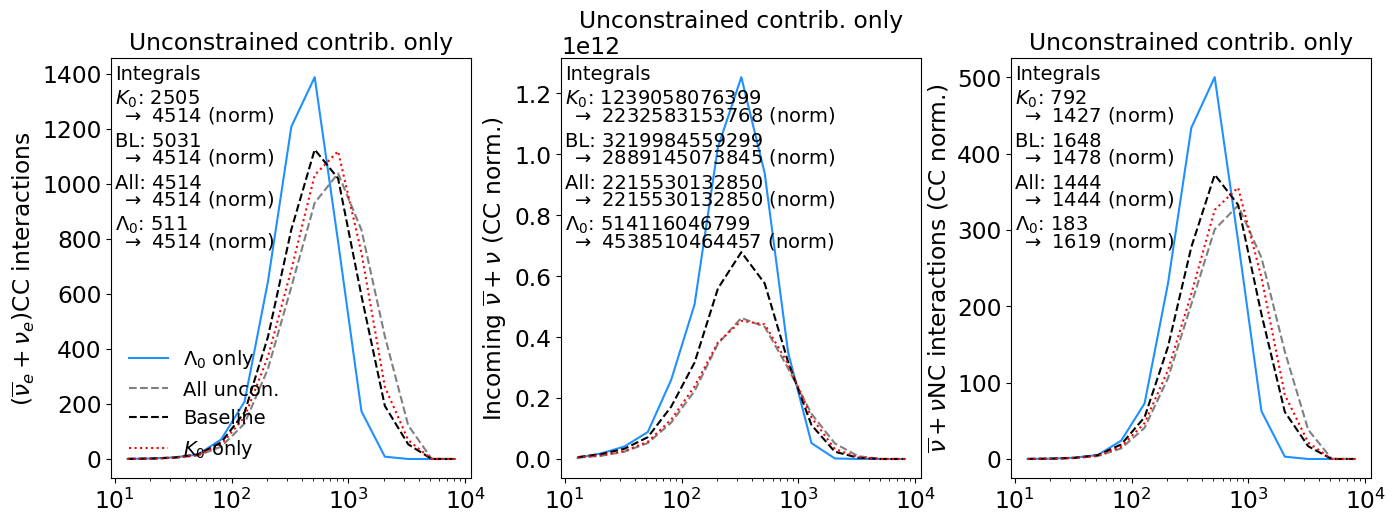

In [29]:
for detector,PS in zip(['FASERv'],['FASER-PS']):
    print(detector,PS)
    print('\Conservative unc:\n')
    unc = hyperonUnc(detector=detector,Hr={'lo':0.,'cn':Lambda0ratio[PS]['cn'],'hi':1.},plotSpectra=True)
    for uncvar in unc: print(uncvar)

#### Test `hyperonUnc` with actual results of hyperon ratio down/up variations (`Hrlo`, `Hrup`)

In [30]:
for detector,PS in zip(['FASERv','FASERv2'],['FASER-PS','FASER2-PS']):
    print(detector,PS)
    unc = hyperonUnc(detector=detector,Hr=Lambda0ratio[PS])
    for uncvar in unc: print(uncvar)

FASERv FASER-PS
[0.113278   0.11360539 0.06864288 0.05244995 0.11352706 0.13000137
 0.21363774 0.21670131 0.12910346 0.05803426 0.25546778 0.36416958
 0.35603043 0.         0.        ]
[0.113278   0.11360539 0.06864288 0.05244995 0.11352706 0.13000137
 0.21363774 0.21670131 0.12910346 0.05803426 0.25546778 0.36416958
 0.35603043 0.         0.        ]
FASERv2 FASER2-PS
[0.03632271 0.03837832 0.01659273 0.01663486 0.03714096 0.04709701
 0.07008711 0.06576348 0.03418183 0.02613954 0.09109805 0.11963243
 0.11834686 0.         0.        ]
[0.02540199 0.05487777 0.02372621 0.02378645 0.05310845 0.06734475
 0.10021866 0.09403624 0.04887713 0.01828048 0.06370868 0.08366397
 0.08276492 0.         0.        ]


The above plots show what consequences the normalization of the total number of CC interactions (left) have to the total numbers of incoming neutrinos (middle) and NC interactions (right). The key message is in the numbers after the arrows in the rightmost plot, giving the total numbers of NC interactions in the baseline, kaon-only and hyperon-only models: even though the number of CC interactions is normalized to the same for the baseline and both extremal spectra (see arrows in the leftmost plot), the total number of NC interactions can change slightly, between the numbers shown after the arrows. Note that imposing the hyperon-only model would imply that the amount of incoming neutrinos is much greater than in the baseline model, but their spectrum also shifts towards lower energies, and cross sections go down quickly with decreasing energies. This intuitively explains why the total number of NC interactions in the hyperon-only model is not so much greater than the baseline amount, although the number of incoming neutrinos is greatly enhanced.

### Constraints on Non-Standard Interactions (NSI)

In the $\epsilon^{qV}_{\ell\ell},\epsilon^{qA}_{\ell\ell}$ space, there will be an ellipse passing through $\epsilon^{qV}_{\ell\ell} = \epsilon^{qA}_{\ell\ell} = 0$, yielding the same number of events as the SM. Points along this ellipse, and some uncertainty band around it, will be indistinguishable from the SM, while points further from the ellipse will result in too many (or few) events.

To determine the width of the uncertainty band, we compute the values
\begin{equation*}
\Delta\chi^2 = \sum_i \left( \frac{N^{\rm SM}_i - N^{\rm NSI}_i (\epsilon^{qA}_{\ell\ell}, \epsilon^{qV}_{\ell\ell}) }
                                  {\sigma^\pm_i}
                      \right)^2,
\end{equation*}
where $N^{\rm SM/NSI}_i$ are the numbers of events predicted by the SM and an NSI model with given values of the Wilson coefficients, and $\sigma^\pm_i$ are the uncertainties, summed over all $E_\nu$ bin indices $i$. 
To account for asymmetric uncertainties, the lower (upper) uncertainty $\sigma^-_i$ ($\sigma^+_i$) is used for each bin $i$ where 
$N^{\rm SM}_i > N^{\rm NSI}_i$ ($N^{\rm SM}_i < N^{\rm NSI}_i$).

Values $\chi^2=0$ are obtained on the SM-equivalent ring, and 68\% confidence level (CL) bounds are found at the contours where $\Delta\chi^2=1$. Note that this is a change in $\chi^2$, not the reduced $\chi^2$ that is divided by the number of degrees of freedom. 
This is important, because the resulting bounds are to be obtained at 95\% CL (2$\sigma$). Naively, $\chi^2 \propto \sigma^{-2}$ would imply that bounds corresponding to $2\sigma$ are obtained by finding the contours at $\chi^2 = 4$, but this is not in general the case; the corresponding $\chi^2$ value can be greater, depending on the number of degrees of freedom $N_{\rm dof}$, which depends on the number of parameters. In the present case, there are 2 parameters: $\epsilon^A$ and $\epsilon^V$, and the $N_{\rm dof}$ are expected to be the number of data points minus the number of parameters (this is also not always the case, if the variables aren't independent etc, but a reasonable assumption in the present case). The numbers of degrees of freedom are returned for each experimental case by the `chi2scan` function that computes the $\chi^2$ grids. In practice, the required $\chi^2$ value could be looked up from a table, and here it is obtained via `chi2` in the `scipy.stats` package by calling `chi2.ppf(CL,Ndof)`.

This method is checked to reproduce the results of 2012.10500, assuming only statistical uncertainties on the number of observed NC interactions, wherein only the incoming muon (anti)neutrinos contribute. The method is generalized to cases with all incoming neutrino flavors contributing to the amount of observed NC interactions, and by adding estimated systematic uncertainties in quadrature with the statistical uncertainties of NC events. The systematics are estimated for cases with and without the plastic scintillator: without it, the uncertainty is the conservative uncertainty outlined above (complete ignorance on the forward hadron composition of the unconstrained part of the $\overline{\nu}_e-\nu_e$ spectrum), and with it (by having constraints on the number of forward hyperon contributions to forward hadron composition). The more the uncertainties $\sigma^\pm_i$ increase, the more the $\Delta\chi^2$ values will go down everywhere on the grid, resulting in wider bands between the requested $\Delta\chi^2$ contours.

In [31]:
#Find the value of a chi2 cost function between a model w/ some epsA, epsV values and the SM
#Param  
#       xpct   The number of expected events
#       unclo  The uncertainties in each energy bin, below expected value, assumed fully uncorrelated
#       unchi  The uncertainties in each energy bin, above expected value, assumed fully uncorrelated
def findchi2(detector,radN,fstat,genpair,qstr,llstr,rmindices,epsV,epsA,usevpids,xpct,unclo,unchi):
    varied = model(detector=detector,\
                   radN=radN,\
                   fstat=fstat,\
                   modelpars={'eps'+qstr+'V_'+llstr: epsV, 'eps'+qstr+'A_'+llstr: epsA},\
                   genpair=genpair,\
                   usevpids=usevpids)
    nint_BSM = np.sum([np.sum([deepcopy(EvsNint) for EvsNint in varied[vpid]['n_nc'].T],axis=0)\
                       for vpid in list(varied.keys())],axis=0)
    pred=np.delete(nint_BSM,rmindices)  #The number of events corresponding to current parameter variations 
    #Use upper (lower) uncertainties depending on whether prediction nints is above (below) expectation
    unc = [unclo[i] if pred[i]<xpct[i] else unchi[i] for i in range(len(unclo))]
    return sum(np.power( np.divide( np.subtract(np.array(xpct),np.array(pred)), unc), 2))

#For multiprocessing
def chi2handle(epsAepsVpercpu,detector,radN,fstat,genpair,qstr,llstr,rmindices,usevpids,xpct,unclo,unchi):
    return [findchi2(detector=detector,radN=radN,fstat=fstat,genpair=genpair,qstr=qstr,llstr=llstr,rmindices=rmindices,\
                     epsV=epsV,epsA=epsA,usevpids=usevpids,xpct=xpct,unclo=unclo,unchi=unchi) for epsA,epsV in epsAepsVpercpu]

In [32]:
#Find the chi2 values for all points on a grid of the combinations of given epsA and epsV values.
#Param
#  detector      The detector to consider
#  radN          E.g. '_rad1'
#  genpair       The generator pair to assume as the baseline prediction
#  fstat         fstat value for the detector
#  epsVvals      The epsilon^qV_ll values to scan through
#  epsAvals      The epsilon^qA_ll values to scan through
#  qstr          The quark flavor q in epsilon^qX_ll as a string, e.g. 'u' or 'd'
#  llstr         The lepton indices in epsilon^qX_ll as a string, e.g. 'ee' or 'mumu'
#  systunc_frac  Two arrays (lo & up errors) of fractional syst. uncertainties, as deviations from zero, one value per ebin.
#  nunubars  The vpids to use, sum nu+nubar contributions per flavor
#Returns a matrix of chi2 values vs SM at different grid points (corresponding to combinations of dGV and dGA), and the #DOF as a number
def chi2scan(detector,radN,genpair,fstat,epsVvals,epsAvals,qstr,llstr,systunc_frac,nunubars=['12','14','16']):
    
    global lambdaBL
    
    #SM baseline model
    baseline = model(detector,
                     radN=radN,
                     lambdamat=deepcopy(lambdaBL),
                     fstat=fstat,\
                     modelpars={},
                     genpair=genpair,\
                     usevpids=nunubars)
    ebins = baseline[list(baseline.keys())[0]]['ebins']
    
    #SM number of interactions
    nint_SM = np.sum([np.sum([deepcopy(EvsNint) for EvsNint in baseline[vpid]['n_nc'].T],\
                             axis=0) for vpid in list(baseline.keys())],axis=0)
    
    #Sum stat and syst unc to get total uncertainty
    statunc = np.sqrt(nint_SM)
    systunc = [np.multiply(nint_SM,systunc_frac[i]) for i in range(len(systunc_frac))]
    unc = [np.sqrt(np.add(np.power(systunc[i],2),np.power(statunc,2))) for i in range(len(systunc))]

    #Check if any unc are zero, to avoid division by zero in chi2. Note that if unc=0, there are no stats in the bin to begin with,
    #and syst unc based on varying Lambda0 and K0 contributions (subsets of total spectrum) will not be able to add any unc to such bins.
    #Since stat unc is symmetric, both up and lo unc will be 0 simultaneously, and we simply remove those indices and the ndof here
    rmindices=[]
    for i in range(len(nint_SM))[::-1]:
        if unc[0][i]==0:
            rmindices.append(i)
            nint_SM = np.delete(nint_SM,i)
            for j in range(len(unc)): unc[j] = np.delete(unc[j], i)
    
    #Number of degrees of freedom
    npar=2  #2 parameters: epsA, epsV
    ndof = len(nint_SM)-npar

    #First, compute most chi2 values using multiprocessing
    epsAepsV = []
    for epsAstr in epsAvals:
        for epsVstr in epsVvals:
            epsAepsV.append([float(epsAstr),float(epsVstr)]) 
    ncpu = cpu_count()
    ncpu = min(ncpu,len(epsAepsV))
    procs = Pool(processes=ncpu)
    calcspercpu = int(len(epsAepsV)/ncpu)
    nextra = len(epsAepsV) - ncpu*calcspercpu #How many computations performed using multiprocessing
    print('#cpu = ',ncpu,', #calculations/cpu = ',calcspercpu)
    print('Computing ',len(epsAepsV)-nextra,'/',len(epsAepsV),' entries using multiprocessing')
    epsAepsVpercpu = np.array([epsAepsV[n*calcspercpu:(n+1)*calcspercpu] for n in range(ncpu)])
    chi2 = np.array(procs.map(partial(chi2handle,detector=detector,radN=radN,fstat=fstat,genpair=genpair,qstr=qstr,llstr=llstr,\
                                      rmindices=rmindices,usevpids=nunubars,xpct=nint_SM,unclo=unc[0],unchi=unc[1]),\
                              epsAepsVpercpu)).flatten()

    #If process count was not divisible by ncpu, compute the remaining entries in another pool
    if nextra > 0:
        print('Computing remaining '+str(nextra)+' entries')
        procs2 = Pool(processes=nextra)
        epsAepsVpercpu2 = np.array([[epsAepsV[n]] for n in range(len(epsAepsV)-nextra,len(epsAepsV))])
        chi2add = np.array(procs2.map(partial(chi2handle,detector=detector,radN=radN,fstat=fstat,genpair=genpair,qstr=qstr,llstr=llstr,\
                                              rmindices=rmindices,usevpids=nunubars,xpct=nint_SM,unclo=unc[0],unchi=unc[1]),\
                                      epsAepsVpercpu2)).flatten()
        chi2 = np.append(chi2,chi2add)
    
    #Reshape chi2 to proper dimensions and return together with number of degrees of freedom
    chi2 = np.reshape(np.array(chi2), (len(epsAvals), len(epsVvals)))  #shape: (nrows, ncols)
    return chi2,ndof

In [33]:
#For computing and filling the values into a global chi2 dictionary, with the keys corresponding to various experiments, qstrs etc.
#Param  tag       Tag indicating the detector to be considered, and optional type of unc (cons/hprn), e.g. 'FASERv-cons'
#       fstat     <In/de>crease statistics by a constant factor
#       qstr      The quark flavor q in epsilon^qX_ll as a string, e.g. 'u' or 'd'
#       llstr     The lepton indices in epsilon^qX_ll as a string, e.g. 'ee' or 'mumu'
#       epsVvals  The epsilon^qV_ll values to scan through
#       epsAvals  The epsilon^qA_ll values to scan through
#       nunubars  The vpids to use, sum nu+nubar contributions per flavor
def fill_chi2_dict(tag,qstr,llstr,epsVvals,epsAvals,fstat=1.0,nunubars=['12','14','16']):
    
    detector=tag.split('-')[0]
    PS = 'FASER2-PS' if '2' in detector else 'FASER-PS'
    print(tag+':',detector,PS)
    _,ecenters,_,_ = get_bins(detector)
    
    #First introduce all uncertainties as positive fractional deviations from the baseline value 0.0
    systunc_frac = [[0. for _ in ecenters] for i in range(2)]  #Lo and hi uncertainties
    
    #Additional systematic contributions to nue
    if 'cons' in tag or 'hprn' in tag:
        if 'hprn' in tag:  #Uncertainty from nubar-nu
            print('Adding hyperon number constraint -based uncertainties')
            addunc = hyperonUnc(detector=detector,Hr=Lambda0ratio[PS])
        else:
            print('Adding conservative uncertainties')
            addunc = hyperonUnc(detector=detector,Hr={'lo':0.,'cn':Lambda0ratio[PS]['cn'],'hi':1.})
        
        #Check array dimensions
        if len(systunc_frac)!=len(addunc): raise ValueError("Lengths of systunc_frac and addunc disagree")
        for i in range(len(systunc_frac)):
            if len(systunc_frac[i])!=len(addunc[i]): raise ValueError("Lengths of systunc_frac[i] and addunc[i] disagree")
        
        #Add quadratically to the initial uncertainties
        systunc_frac = [np.sqrt(np.add(np.power(systunc_frac[i],2), np.power(addunc[i],2))) for i in range(len(addunc))]
    
    return chi2scan(detector=detector,\
                    radN='_rad1',\
                    genpair=genpairBL,\
                    fstat=fstat,\
                    epsVvals=epsVvals,\
                    epsAvals=epsAvals,
                    qstr=qstr,\
                    llstr=llstr,\
                    systunc_frac=systunc_frac,\
                    nunubars=nunubars)

In [34]:
#Init global dictionaries for storing results
chi2_NSI={}
ndof_NSI={}
NSIquarks = ['d','u']  #Produce NSI bound plots for these quarks
ngrid=151
epsVfine = {'d':np.linspace(-0.75,1.25,ngrid), 'u':np.linspace(-1.3,0.7,ngrid)}
epsAfine = {'d':np.linspace(-1.50,0.50,ngrid), 'u':np.linspace(-0.5,1.5,ngrid)}

In [35]:
#Plot contours based on the constraints on the number of events
#Param  chi2dict  Matrices containing the chi2 corresponding to a combination of row&col variables,
#                 one matrix per experiment (combination) & fstat -pair.
#       rows      A vector containing the values to which the matrix rows correspond to 
#       cols                               -||-                      columns   -||- 
#       plotinfo  A dictionary containing the experiment tags to be plotted as keys, and plot options in a subdictionary as values
#       qstr      The quark flavor q in epsilon^qX_ll as a string, e.g. 'u' or 'd'
#       llstr     The lepton indices in epsilon^qX_ll as a string, e.g. 'ee' or 'mumu'
#       CL        Requested confidence level
#       ndofdict  A dictionary containing the numbers of degrees of freedom, corresponding to the chi2 in chi2dict
def contourplot(chi2dict,rows,cols,plotinfo,qstr,llstr,CL,ndofdict,experimentlabel,runstr):
    
    #Init
    fig = plt.figure(figsize=(8,5))
    ax = fig.add_axes([0.16, 0.15, 0.83, 0.84],)
    axes = np.array([[ax]])        
    alpha=0.3       #For enabling see-through fills
       
    #Ensure grid format and datatype based on input rows (y-axis) and cols (x-axis). N.B. values may be strings
    X,Y = np.meshgrid([float(d) for d in cols],[float(d) for d in rows])
           
    #Indicate SM point via the intersection of two lines
    approxInfty=10  #Large enough to always lies outside axis limits. No computational purpose here.
    plt.plot([0.0,0.0],                  [-approxInfty,approxInfty], linestyle=(0, (5, 7)), lw=0.5, color='black')
    plt.plot([-approxInfty,approxInfty], [0.0,0.0],                  linestyle=(0, (5, 7)), lw=0.5, color='black')

    #Previous constraints for comparison
    #Plotstyle setup: experiment tag for filenames: [exp name, line style, line color, fill color]
    prev={'CHARM':        {'name':r'CHARM',         'sfx':['outer','inner'], 'ls':'solid', 'fc':'silver' },\
          'osc+COHERENT': {'name':r'Osc.+COHERENT', 'sfx':['left', 'right'], 'ls':'solid', 'fc':'dimgray'}}
    for key in prev:
        prev[key]['out'] = [np.loadtxt('files/previous_constraints/cid_NSI/'+key+'_'+qstr+'_'+prev[key]['sfx'][0]+'.dat',usecols=0),\
                            np.loadtxt('files/previous_constraints/cid_NSI/'+key+'_'+qstr+'_'+prev[key]['sfx'][0]+'.dat',usecols=1)]
        prev[key]['in'] = [np.loadtxt('files/previous_constraints/cid_NSI/'+key+'_'+qstr+'_'+prev[key]['sfx'][1]+'.dat',usecols=0),\
                           np.loadtxt('files/previous_constraints/cid_NSI/'+key+'_'+qstr+'_'+prev[key]['sfx'][1]+'.dat',usecols=1)]
        plt.fill(np.append(prev[key]['out'][0],prev[key]['in'][0][::-1]),\
                 np.append(prev[key]['out'][1],prev[key]['in'][1][::-1]),\
                 linewidth=0.,color=prev[key]['fc'], alpha=0.5)
    
    #Plot result contours (in reverse s.t. darkest stat-only band is drawn on top
    for key in list(plotinfo.keys())[::-1]:
        lstyle='dotted' if '%' in key else 'solid'
        lvl = chi2.ppf(CL, ndofdict[key][qstr][llstr])
        cntr = plt.contour(X,Y,chi2dict[key][qstr][llstr],levels=[lvl],colors=[plotinfo[key]['color']],\
                           linestyles=[lstyle],linewidths=[0.5])
        if key!='FASERv2':
            plt.fill(cntr.get_paths()[0].vertices[:,0], cntr.get_paths()[0].vertices[:,1],\
                     linewidth = 0,\
                     color = plotinfo[key]['color'],
                     facecolor = 'none' if 'hatch' in plotinfo[key] else plotinfo[key]['color'],
                     hatch = None if 'hatch' not in plotinfo[key] else plotinfo[key]['hatch'])
        else:
            plt.plot(cntr.get_paths()[0].vertices[:,0], cntr.get_paths()[0].vertices[:,1],\
                     linewidth = 0,\
                     markersize = 7,\
                     marker = '.',\
                     color = plotinfo[key]['color'])
    
    #For adding previous bounds to legend and plotting outlines on top
    plt.plot([-10],[-10],color='white',label=r'$\bf{Previous}$')
    for key in prev:
        plt.fill([-10,-10,-9,-9],[-10,-9,-9,-10],linewidth=0.,color=prev[key]['fc'],alpha=0.5,label=prev[key]['name'])
        plt.plot(prev[key]['out'][0],prev[key]['out'][1],linestyle=prev[key]['ls'],linewidth=0.5,color='black')
        plt.plot(prev[key]['in' ][0],prev[key]['in' ][1],linestyle=prev[key]['ls'],linewidth=0.5,color='black')

    #Add labels to legend in reverse
    plt.plot([-10],[-10],color='white',label=runstr)
    for key in plotinfo:
        plt.fill([-10,-10,-9,-9],[-10,-9,-9,-10],\
                 linewidth = 0,\
                 color = plotinfo[key]['color'],
                 label = None if 'label' not in list(plotinfo[key].keys()) else plotinfo[key]['label'],\
                 facecolor = 'none' if 'hatch' in plotinfo[key] else plotinfo[key]['color'],
                 hatch = None if 'hatch' not in plotinfo[key] else plotinfo[key]['hatch'])

    #Finalize figure setup
    matplotlib.rcParams.update({'legend.loc':'lower left'})
    leg = plt.legend(frameon=False, facecolor='white')
    llstrltx = llstr
    if llstr=='mumu':   llstrltx = '\mu\mu'
    if llstr=='tautau': llstrltx = '\tau\tau'
    plt.xlabel(r'$\epsilon^{'+qstr+'V}_{'+llstrltx+'}$')
    plt.ylabel(r'$\epsilon^{'+qstr+'A}_{'+llstrltx+'}$')
    if qstr=='d':
        plt.xlim(-1.40,1.20)  #epsV
        plt.ylim(-1.35,0.35)  #epsA
    else:
        plt.xlim(-1.7,0.6)   #epsV
        plt.ylim(-0.3,1.3)   #epsA

    #Print experiment label
    xmin,xmax = plt.xlim()
    ymin,ymax = plt.ylim()
    print('xmin',xmin,'xmax',xmax,'ymin',ymin,'ymax',ymax)
    plt.text(0.02*(xmax-xmin)+xmin, 0.94*(ymax-ymin)+ymin, experimentlabel)
    
    #Save figure
    filename = 'plots/'+'eps'+qstr+llstr+'_constraints_'+('_'.join(list(plotinfo.keys()))).replace('%','p')+'.pdf'
    if filename is not None: 
        plt.savefig(filename)
        print('Saved',filename)
    plt.show()
    plt.clf()    

### Reproduce 2012.10500

Include only statistical uncertainty. 
In order to correspond to the run3 lumi of 150/fb, vs run4 lumi of 680/fb, the run3 result is obtained using fstat ~0.22

In [36]:
#Computations
for tag in ['FASERv-run3']:
    chi2_NSI[tag],ndof_NSI[tag] = {},{}
    for qstr in NSIquarks:
        print(qstr)
        chi2_NSI[tag][qstr],ndof_NSI[tag][qstr] = {},{}
        for llstr in ['mumu']:    
            ## All (anti)neutrinos contribute to the NC signal
            #tmp=fill_chi2_dict(tag=tag,qstr=qstr,llstr=llstr,epsVvals=epsVfine[qstr],epsAvals=epsAfine[qstr],\
            #                   fstat=150./experiments['FASERv']['lumi'])
            ## Restrict to muon (anti)neutrinos only, as stated in the paper
            tmp = fill_chi2_dict(tag=tag,qstr=qstr,llstr=llstr,epsVvals=epsVfine[qstr],epsAvals=epsAfine[qstr],\
                                 fstat=150./experiments['FASERv']['lumi'],nunubars=['14'])
            chi2_NSI[tag][qstr][llstr], ndof_NSI[tag][qstr][llstr] = tmp

d
FASERv-run3: FASERv FASER-PS
#cpu =  16 , #calculations/cpu =  1425
Computing  22800 / 22801  entries using multiprocessing
Computing remaining 1 entries
u
FASERv-run3: FASERv FASER-PS
#cpu =  16 , #calculations/cpu =  1425
Computing  22800 / 22801  entries using multiprocessing
Computing remaining 1 entries


xmin -1.4 xmax 1.2 ymin -1.35 ymax 0.35
Saved plots/epsdmumu_constraints_FASERv-run3.pdf


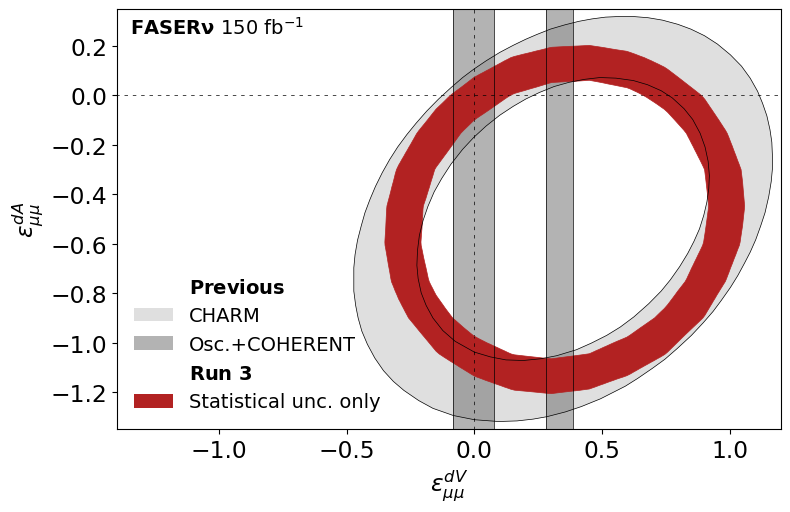

xmin -1.7 xmax 0.6 ymin -0.3 ymax 1.3
Saved plots/epsumumu_constraints_FASERv-run3.pdf


<Figure size 640x480 with 0 Axes>

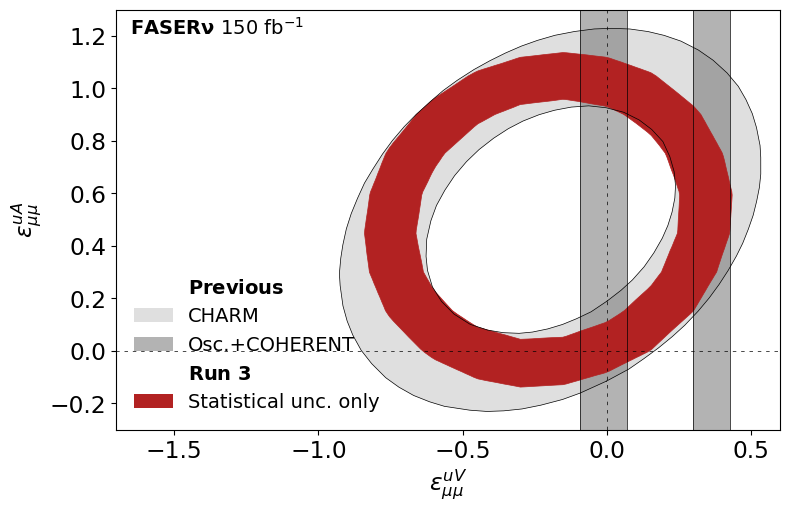

<Figure size 640x480 with 0 Axes>

In [37]:
#Plots
plotinfo = {'FASERv-run3': {'color': 'firebrick', 'label': r'Statistical unc. only'}}
llstr = 'mumu'
for qstr in NSIquarks:
    contourplot(chi2dict=chi2_NSI,\
                rows=epsAfine[qstr],\
                cols=epsVfine[qstr],\
                plotinfo=plotinfo,\
                qstr=qstr,\
                llstr=llstr,\
                CL=0.95,\
                ndofdict=ndof_NSI,\
                experimentlabel=r'$\bf{FASER\nu}$ 150 fb$^{-1}$',\
                runstr=r'$\bf{Run~3}$')

### New results with run4 lumi

Start by including only statistical uncertainties. Then include uncertainty estimates also for systematics and stat summed in quadrature.

In [38]:
#Computations
llstr='mumu'
for tag in ['FASERv','FASERv-cons','FASERv-hprn']:
    chi2_NSI[tag],ndof_NSI[tag] = {},{}
    for qstr in NSIquarks:
        print(qstr)
        chi2_NSI[tag][qstr],ndof_NSI[tag][qstr] = {},{}
        tmp = fill_chi2_dict(tag=tag,qstr=qstr,llstr=llstr,epsVvals=epsVfine[qstr],epsAvals=epsAfine[qstr],fstat=1.0)
        chi2_NSI[tag][qstr][llstr], ndof_NSI[tag][qstr][llstr] = tmp

d
FASERv: FASERv FASER-PS
#cpu =  16 , #calculations/cpu =  1425
Computing  22800 / 22801  entries using multiprocessing
Computing remaining 1 entries
u
FASERv: FASERv FASER-PS
#cpu =  16 , #calculations/cpu =  1425
Computing  22800 / 22801  entries using multiprocessing
Computing remaining 1 entries
d
FASERv-cons: FASERv FASER-PS
Adding conservative uncertainties
#cpu =  16 , #calculations/cpu =  1425
Computing  22800 / 22801  entries using multiprocessing
Computing remaining 1 entries
u
FASERv-cons: FASERv FASER-PS
Adding conservative uncertainties
#cpu =  16 , #calculations/cpu =  1425
Computing  22800 / 22801  entries using multiprocessing
Computing remaining 1 entries
d
FASERv-hprn: FASERv FASER-PS
Adding hyperon number constraint -based uncertainties
#cpu =  16 , #calculations/cpu =  1425
Computing  22800 / 22801  entries using multiprocessing
Computing remaining 1 entries
u
FASERv-hprn: FASERv FASER-PS
Adding hyperon number constraint -based uncertainties
#cpu =  16 , #calculati

xmin -1.4 xmax 1.2 ymin -1.35 ymax 0.35
Saved plots/epsdmumu_constraints_FASERv_FASERv-hprn_FASERv-cons.pdf


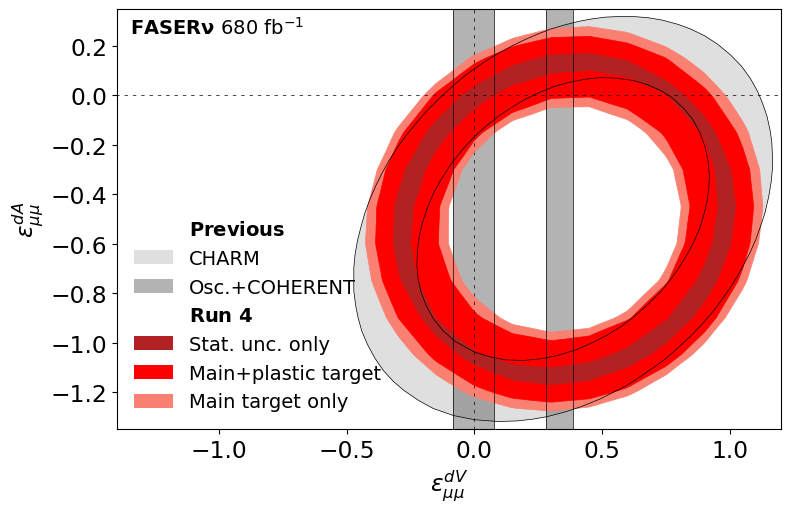

xmin -1.7 xmax 0.6 ymin -0.3 ymax 1.3
Saved plots/epsumumu_constraints_FASERv_FASERv-hprn_FASERv-cons.pdf


<Figure size 640x480 with 0 Axes>

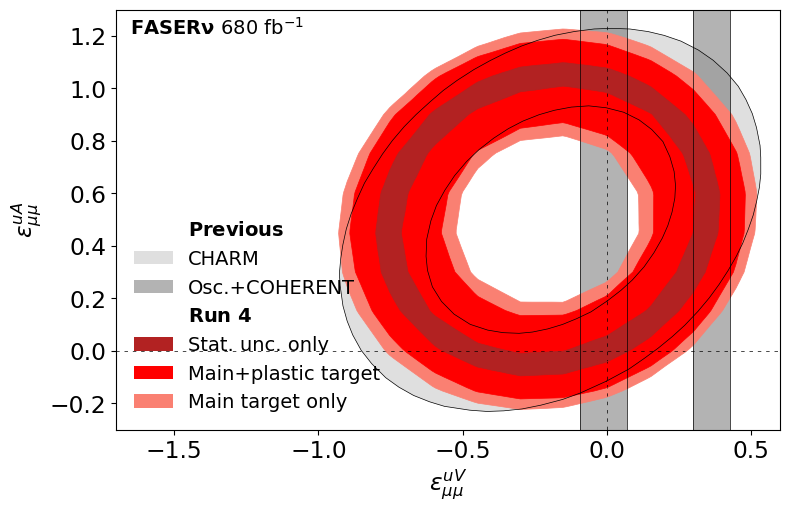

<Figure size 640x480 with 0 Axes>

In [39]:
#Plots
plotinfo = {'FASERv':      {'label': r'Stat. unc. only',\
                            'color': 'firebrick'},\
            'FASERv-hprn': {'label': 'Main+plastic target',\
                            'color': 'red'},\
            'FASERv-cons': {'label': 'Main target only',\
                            'color': 'salmon'}}
llstr = 'mumu'
for qstr in NSIquarks:
    contourplot(chi2dict=chi2_NSI,\
                rows=epsAfine[qstr],\
                cols=epsVfine[qstr],\
                plotinfo=plotinfo,\
                qstr=qstr,\
                llstr=llstr,\
                CL=0.95,\
                ndofdict=ndof_NSI,\
                experimentlabel=r'$\bf{FASER\nu}$ '+str(experiments['FASERv']['lumi'])+r' fb$^{-1}$',\
                runstr=r'$\bf{Run~4}$')

### FASER$\nu$2 results, hi-lumi run

In [40]:
#Computations
llstr='mumu'    
for tag in ['FASERv2','FASERv2-cons','FASERv2-hprn']:
    chi2_NSI[tag],ndof_NSI[tag] = {},{}
    for qstr in NSIquarks:
        print(qstr)
        chi2_NSI[tag][qstr],ndof_NSI[tag][qstr] = {},{}
        tmp = fill_chi2_dict(tag=tag,qstr=qstr,llstr=llstr,epsVvals=epsVfine[qstr],epsAvals=epsAfine[qstr],fstat=1.0)
        chi2_NSI[tag][qstr][llstr], ndof_NSI[tag][qstr][llstr] = tmp

d
FASERv2: FASERv2 FASER2-PS
#cpu =  16 , #calculations/cpu =  1425
Computing  22800 / 22801  entries using multiprocessing
Computing remaining 1 entries
u
FASERv2: FASERv2 FASER2-PS
#cpu =  16 , #calculations/cpu =  1425
Computing  22800 / 22801  entries using multiprocessing
Computing remaining 1 entries
d
FASERv2-cons: FASERv2 FASER2-PS
Adding conservative uncertainties
#cpu =  16 , #calculations/cpu =  1425
Computing  22800 / 22801  entries using multiprocessing
Computing remaining 1 entries
u
FASERv2-cons: FASERv2 FASER2-PS
Adding conservative uncertainties
#cpu =  16 , #calculations/cpu =  1425
Computing  22800 / 22801  entries using multiprocessing
Computing remaining 1 entries
d
FASERv2-hprn: FASERv2 FASER2-PS
Adding hyperon number constraint -based uncertainties
#cpu =  16 , #calculations/cpu =  1425
Computing  22800 / 22801  entries using multiprocessing
Computing remaining 1 entries
u
FASERv2-hprn: FASERv2 FASER2-PS
Adding hyperon number constraint -based uncertainties
#cpu 

xmin -1.4 xmax 1.2 ymin -1.35 ymax 0.35
Saved plots/epsdmumu_constraints_FASERv2_FASERv2-hprn_FASERv2-cons.pdf


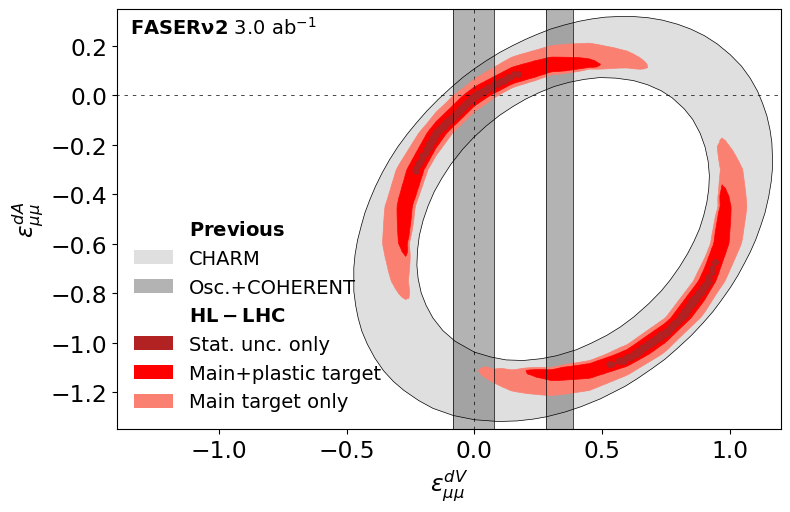

xmin -1.7 xmax 0.6 ymin -0.3 ymax 1.3
Saved plots/epsumumu_constraints_FASERv2_FASERv2-hprn_FASERv2-cons.pdf


<Figure size 640x480 with 0 Axes>

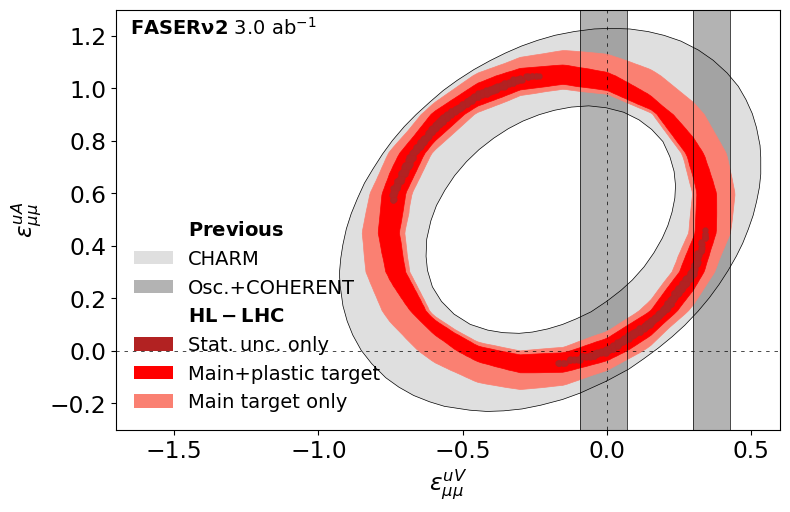

<Figure size 640x480 with 0 Axes>

In [41]:
#Plots
plotinfo = {'FASERv2':      {'label': r'Stat. unc. only',\
                             'color': 'firebrick'},\
            'FASERv2-hprn': {'label': 'Main+plastic target',\
                             'color': 'red'},\
            'FASERv2-cons': {'label': 'Main target only',\
                             'color': 'salmon'}}

llstr = 'mumu'
for qstr in NSIquarks:
    contourplot(chi2dict=chi2_NSI,\
                rows=epsAfine[qstr],\
                cols=epsVfine[qstr],\
                plotinfo=plotinfo,\
                qstr=qstr,\
                llstr=llstr,\
                CL=0.95,\
                ndofdict=ndof_NSI,\
                experimentlabel=r'$\bf{FASER\nu2}$ '+str(experiments['FASERv2']['lumi']/1000)+r' ab$^{-1}$',\
                runstr=r'$\bf{HL-LHC}$')